In [1]:
# ──────────────────────────── IMPORTS ────────────────────────────
from pathlib import Path
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
# ──────────────────────────── CONFIG ────────────────────────────
DATA_FILE  = "cleaned_hurricane_damage_data.csv"
N_CLUSTERS = 8
SVI_EPOCHS = 2000
LR         = 1e-2
SHOW_MAPS  = True
SEED       = 42
pyro.set_rng_seed(SEED); np.random.seed(SEED)

FEATURES = ["log_pop", "log_medinc", "pct_unemp", "pct_crowd", "ppt_mean", "tmean_mean"]
TARGET   = "Damage to Property"

# ──────────────────────────── MODEL ────────────────────────────
def model(X, y=None):
    n = X.shape[1]
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(n), 10.).to_event(1))
    alpha = pyro.sample("alpha", dist.Normal(0., 10.))
    sigma = pyro.sample("sigma", dist.HalfNormal(10.))
    mu = alpha + (X * beta).sum(-1)
    with pyro.plate("obs", X.size(0)):
        pyro.sample("y", dist.Normal(mu, sigma), obs=y)

def guide(X, y=None):
    n = X.shape[1]
    beta_loc   = pyro.param("beta_loc", torch.zeros(n))
    beta_scale = pyro.param("beta_scale", torch.ones(n), constraint=dist.constraints.positive)
    alpha_loc  = pyro.param("alpha_loc", torch.tensor(0.))
    alpha_scale= pyro.param("alpha_scale", torch.tensor(1.), constraint=dist.constraints.positive)
    sigma_loc  = pyro.param("sigma_loc", torch.tensor(1.), constraint=dist.constraints.positive)
    pyro.sample("beta",  dist.Normal(beta_loc, beta_scale).to_event(1))
    pyro.sample("alpha", dist.Normal(alpha_loc, alpha_scale))
    pyro.sample("sigma", dist.HalfNormal(sigma_loc + 1e-3))

In [3]:
# ──────────────────────────── TRAINING ────────────────────────────
def tensors_from_df(df, scaler=None):
    X = df[FEATURES].to_numpy()
    y = np.log1p(df[TARGET].values)
    scaler = StandardScaler().fit(X) if scaler is None else scaler
    return torch.tensor(scaler.transform(X), dtype=torch.float32), torch.tensor(y, dtype=torch.float32), scaler

def train_svi(Xtr, ytr, Xval=None, yval=None, epochs=SVI_EPOCHS):
    pyro.clear_param_store()
    svi = SVI(model, guide, Adam({"lr": LR}), loss=Trace_ELBO())
    tl, vl = [], []
    for _ in range(epochs):
        tl.append(svi.step(Xtr, ytr))
        if Xval is not None:
            with torch.no_grad():
                vl.append(svi.loss(model, guide, Xval, yval))
    return tl, vl

def predict(df, scaler):
    X, y_true, _ = tensors_from_df(df, scaler)
    with torch.no_grad():
        alpha = pyro.param("alpha_loc").item()
        beta  = pyro.param("beta_loc").detach().numpy()
        y_hat = alpha + (X.numpy() @ beta)
    return y_hat, y_true.numpy()

In [4]:
# ──────────────────────────── EVALUATION ────────────────────────────
def compute_metrics(y_true_log, y_pred_log):
    return {
        "MAE":  mean_absolute_error(y_true_log, y_pred_log),
        "RMSE": np.sqrt(mean_squared_error(y_true_log, y_pred_log)),
        "R2":   r2_score(y_true_log, y_pred_log),
    }

def plot_elbo(tr, val=None, title="ELBO"):
    plt.figure(figsize=(5,3))
    plt.plot(tr, label="train")
    if val: plt.plot(val, label="val")
    plt.xlabel("epoch"); plt.ylabel("ELBO (-loss)"); plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

def plot_residuals(y_true_log, y_pred_log, title="Residuals (log space)"):
    res = y_pred_log - y_true_log
    plt.figure(figsize=(5,3))
    plt.scatter(y_true_log, res, alpha=.4)
    plt.axhline(0, color="r", ls="--")
    plt.xlabel("True (log)"); plt.ylabel("Residual (log)"); plt.title(title); plt.tight_layout(); plt.show()

def plot_clusters_map(df, held_cluster=None, title="Spatial Clusters"):
    proj = ccrs.Mercator()
    ax = plt.axes(projection=proj)
    ax.set_extent([-125, -66, 24, 50], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.STATES, linewidth=.4)
    ax.add_feature(cfeature.COASTLINE, linewidth=.5)
    ax.scatter(df["Longitude"], df["Latitude"], c=df["cluster"], cmap="tab10",
               s=12, transform=ccrs.PlateCarree(), alpha=.7)
    if held_cluster is not None:
        held_df = df[df["cluster"] == held_cluster]
        ax.scatter(held_df["Longitude"], held_df["Latitude"], facecolors='none', edgecolors='k',
                   s=40, transform=ccrs.PlateCarree(), label="Held-out Cluster")
        ax.legend()
    plt.title(title)
    plt.tight_layout()
    plt.show()



Loaded cleaned data → 106074 rows


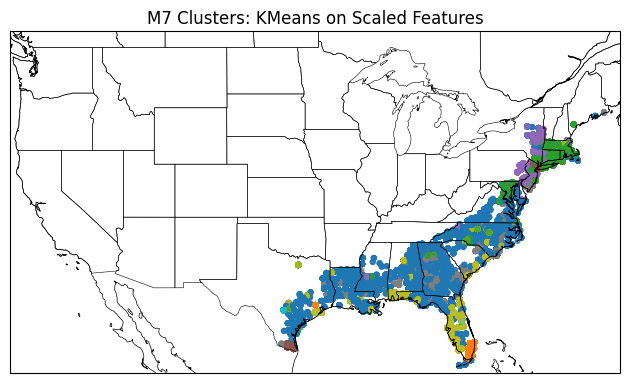


=== Leave-One-Year-Out Test: 2010 ===
  → Evaluating cluster 0 in year 2010


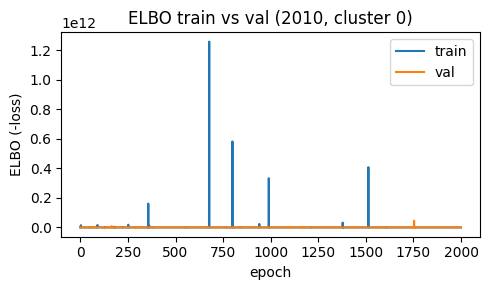

    Metrics (log space) → MAE=5.29, RMSE=6.01, R2=-0.27


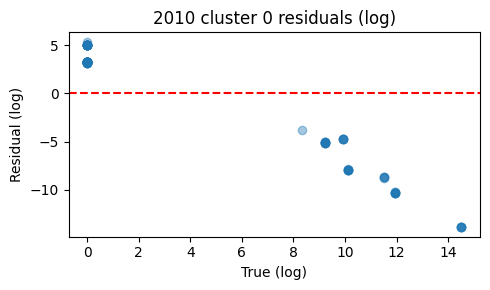

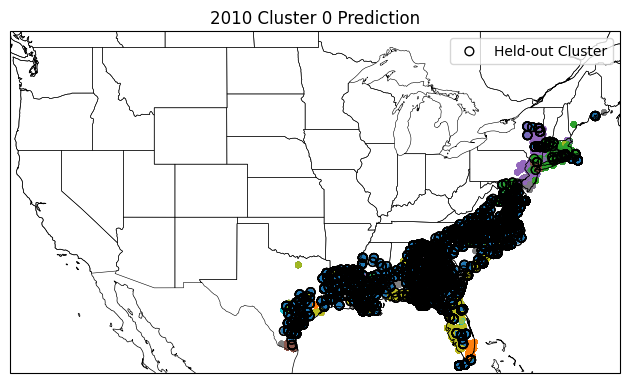

  → Evaluating cluster 2 in year 2010


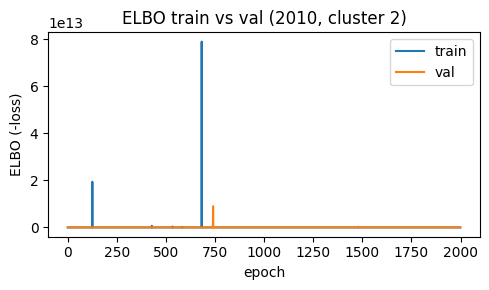

    Metrics (log space) → MAE=1.47, RMSE=1.77, R2=-0.82


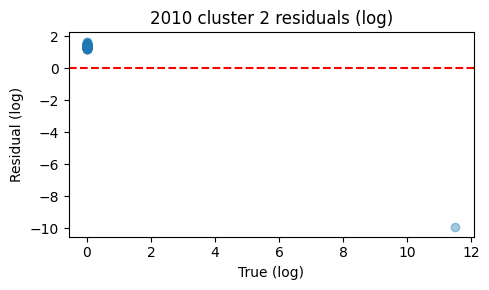

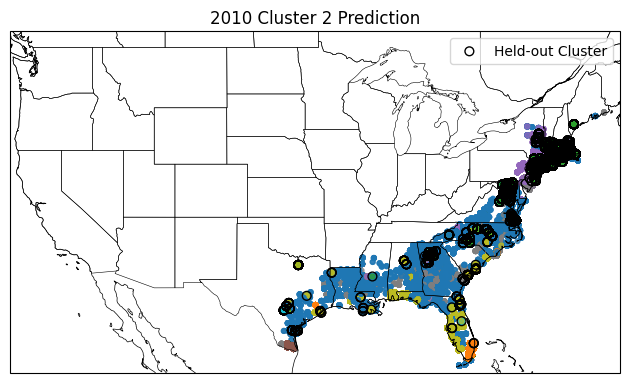

  → Evaluating cluster 3 in year 2010


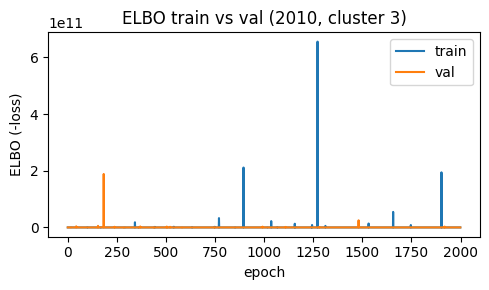

    Metrics (log space) → MAE=4.04, RMSE=4.04, R2=0.00


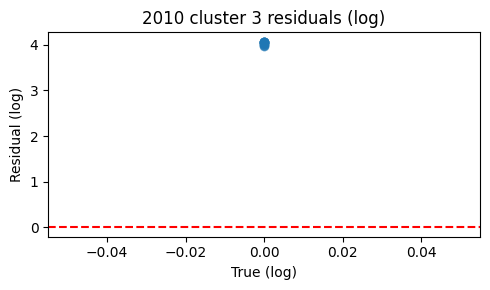

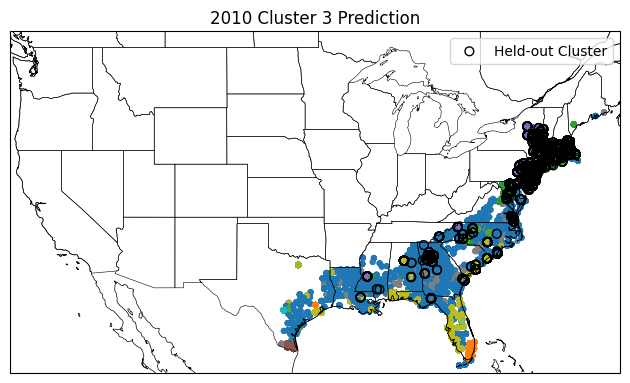

  → Evaluating cluster 4 in year 2010


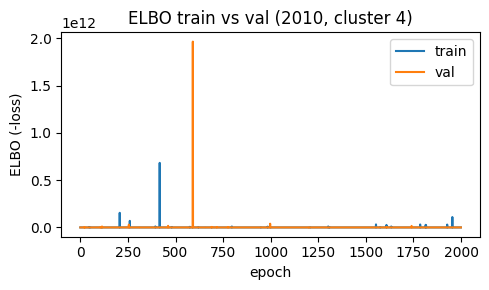

    Metrics (log space) → MAE=13.46, RMSE=13.66, R2=-34.22


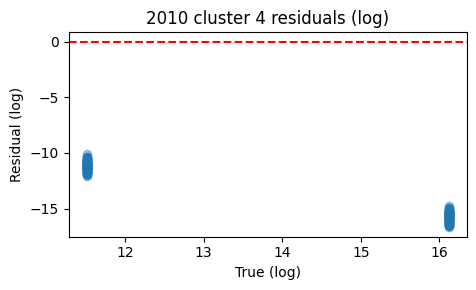

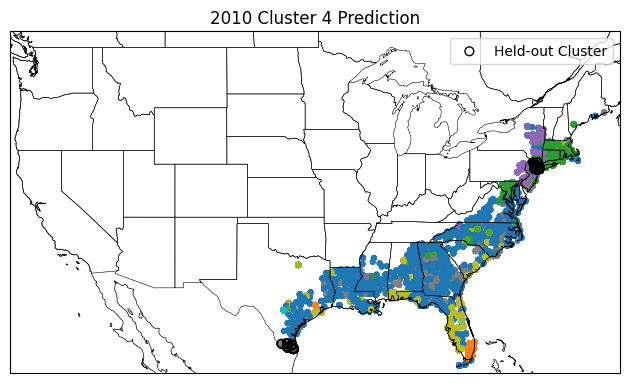

  → Evaluating cluster 5 in year 2010


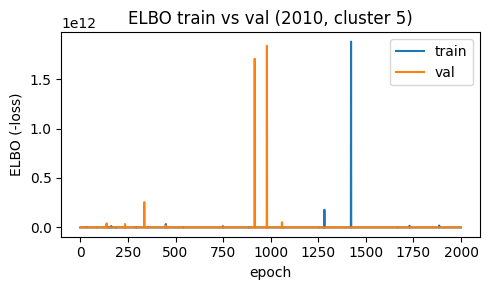

    Metrics (log space) → MAE=4.70, RMSE=5.16, R2=-0.23


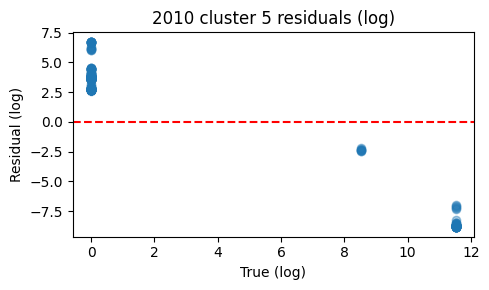

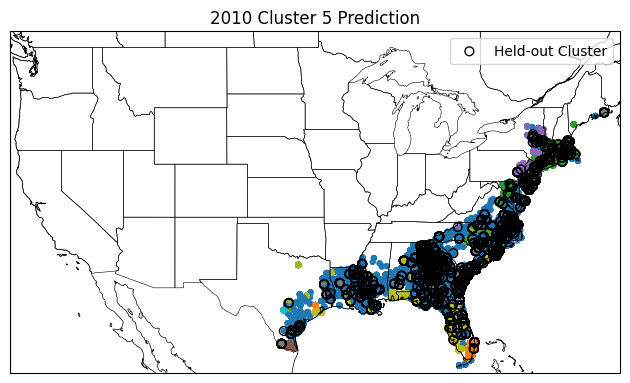

  → Evaluating cluster 6 in year 2010


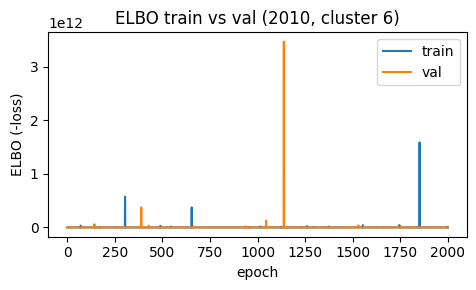

    Metrics (log space) → MAE=1.36, RMSE=1.36, R2=0.00


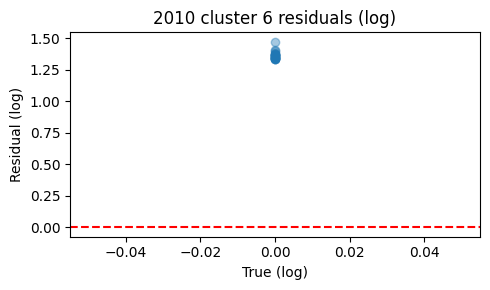

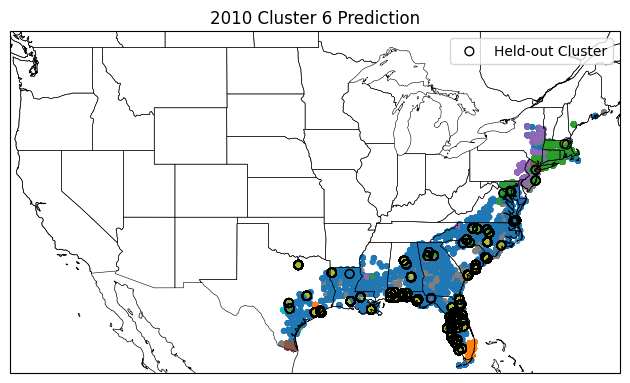

  → Evaluating cluster 7 in year 2010


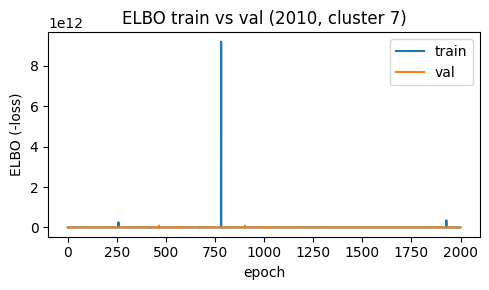

    Metrics (log space) → MAE=8.07, RMSE=8.19, R2=-17.58


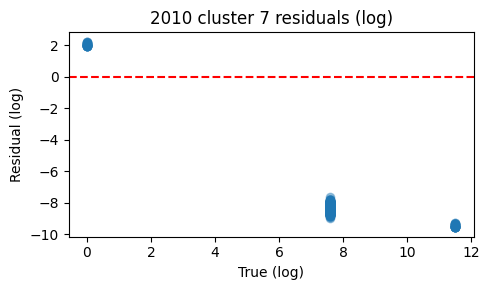

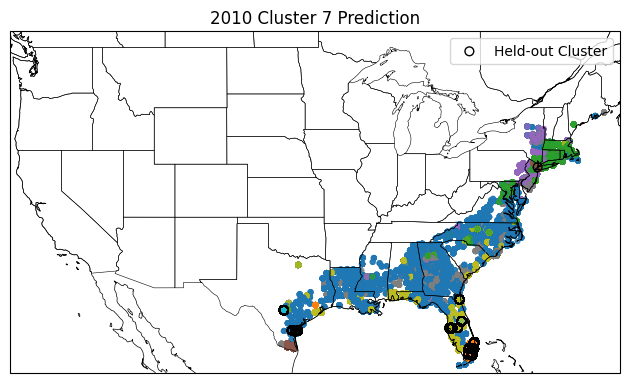


=== Leave-One-Year-Out Test: 2011 ===
  → Evaluating cluster 0 in year 2011


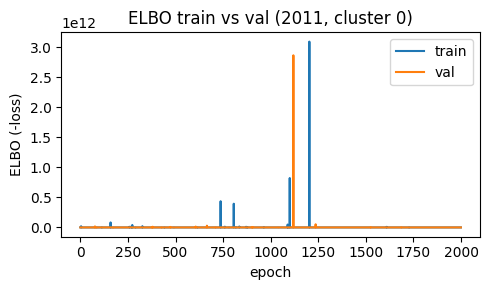

    Metrics (log space) → MAE=5.96, RMSE=6.38, R2=-0.44


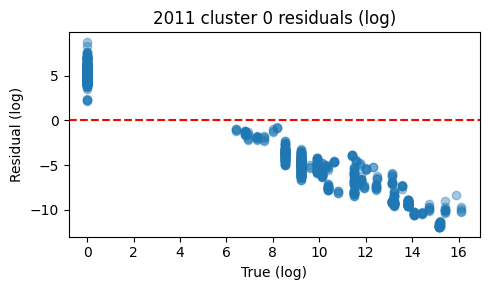

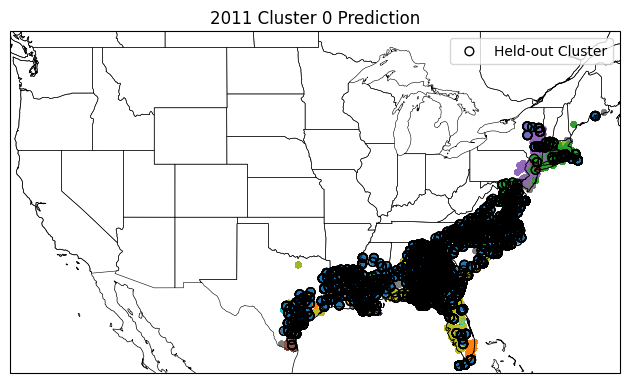

  → Evaluating cluster 2 in year 2011


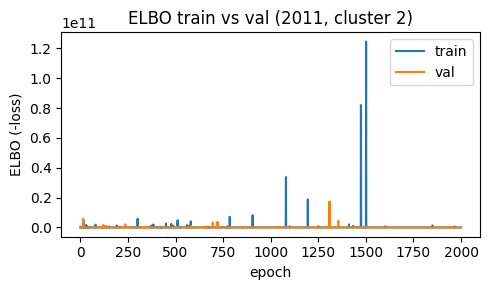

    Metrics (log space) → MAE=5.89, RMSE=6.62, R2=-0.02


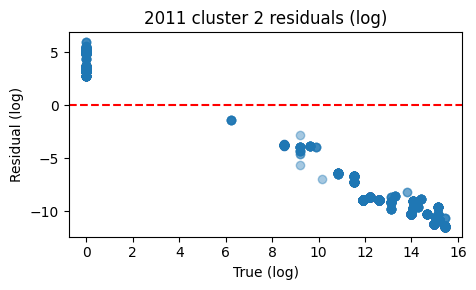

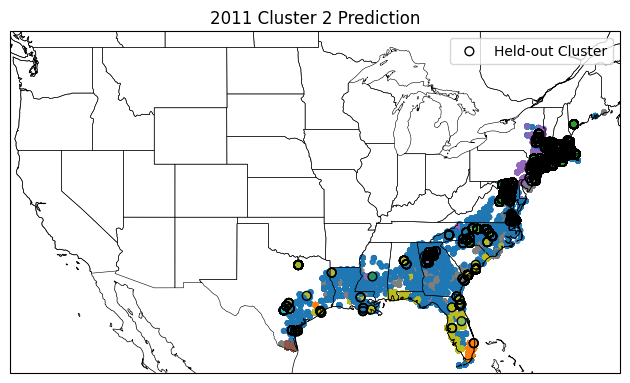

  → Evaluating cluster 3 in year 2011


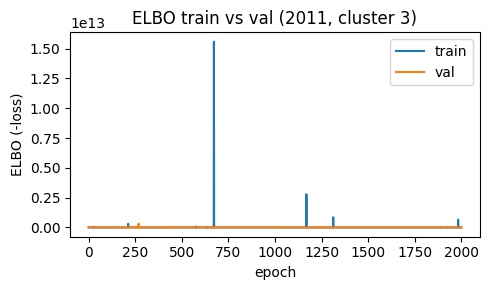

    Metrics (log space) → MAE=8.03, RMSE=9.07, R2=-0.93


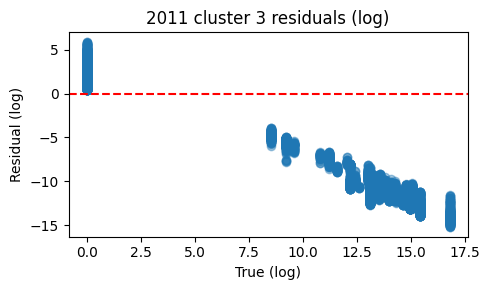

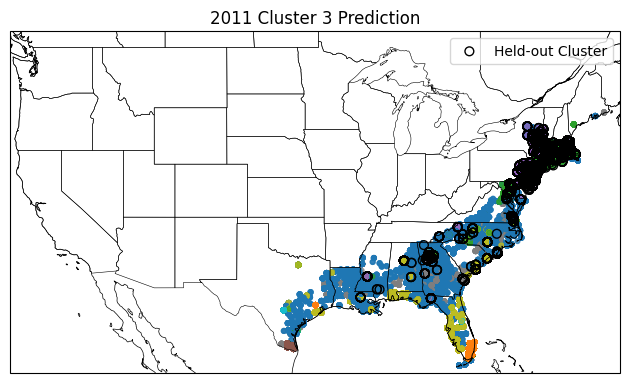

  → Evaluating cluster 4 in year 2011


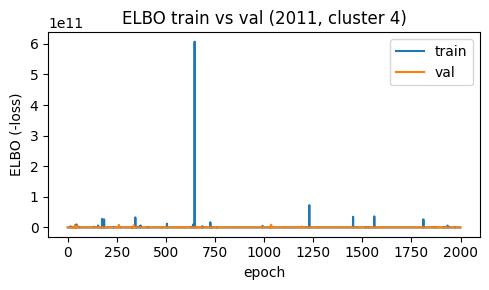

    Metrics (log space) → MAE=2.26, RMSE=2.35, R2=0.00


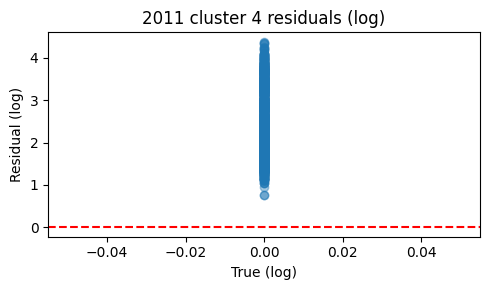

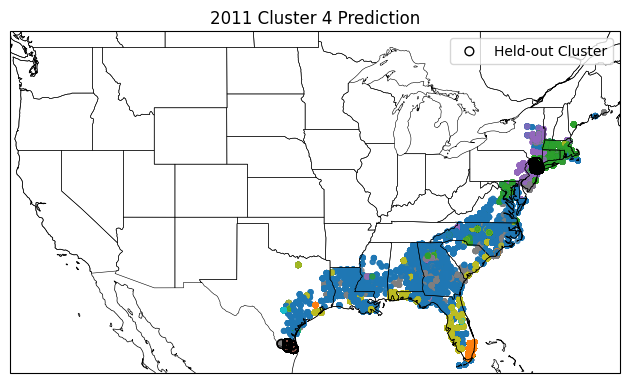

  → Evaluating cluster 5 in year 2011


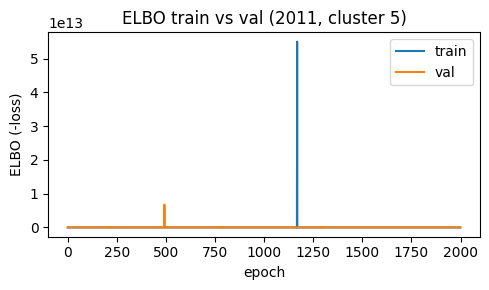

    Metrics (log space) → MAE=5.91, RMSE=6.49, R2=-0.11


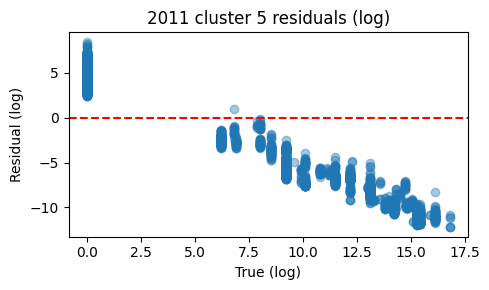

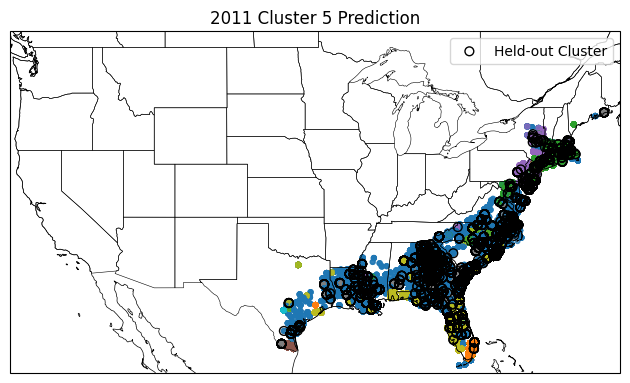

  → Evaluating cluster 6 in year 2011


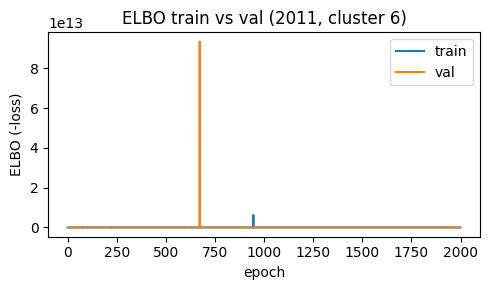

    Metrics (log space) → MAE=9.12, RMSE=9.28, R2=-21.79


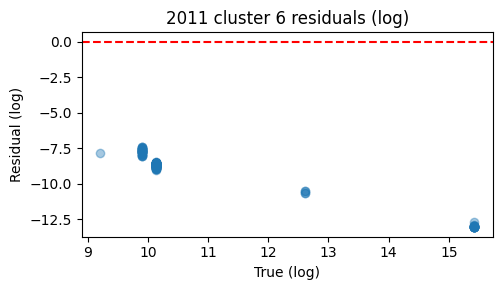

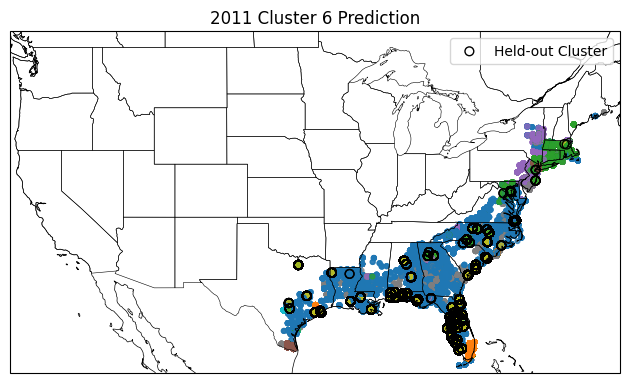


=== Leave-One-Year-Out Test: 2012 ===
  → Evaluating cluster 0 in year 2012


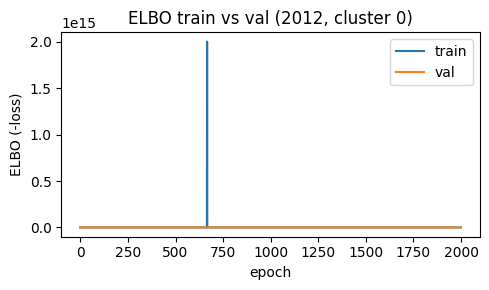

    Metrics (log space) → MAE=8.52, RMSE=9.17, R2=-3.98


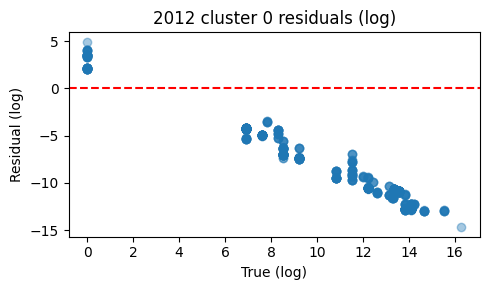

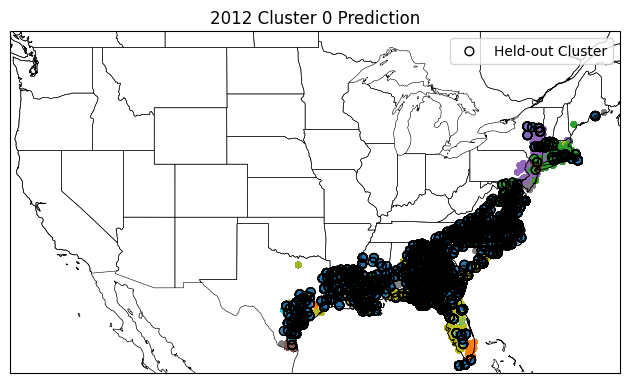

  → Evaluating cluster 2 in year 2012


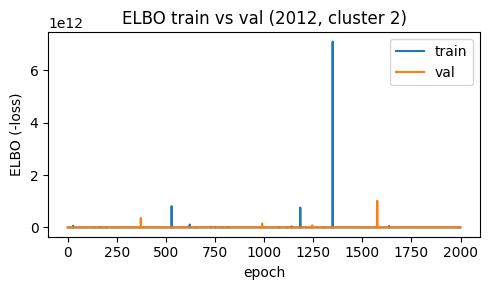

    Metrics (log space) → MAE=2.78, RMSE=2.97, R2=0.13


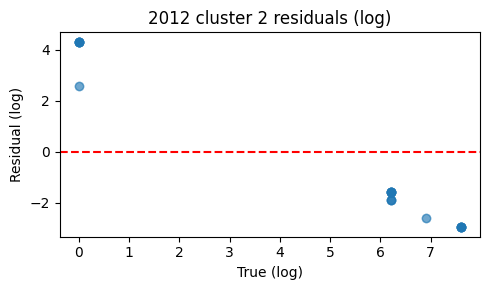

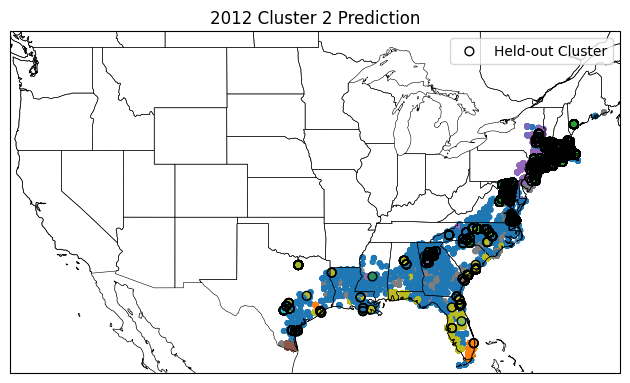

  → Evaluating cluster 3 in year 2012


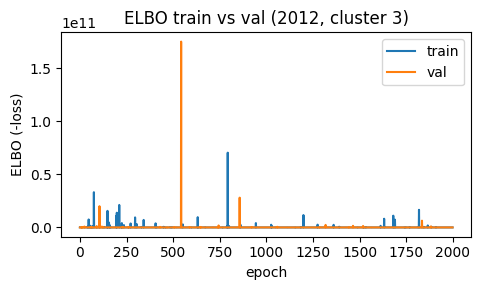

    Metrics (log space) → MAE=4.22, RMSE=5.08, R2=-0.24


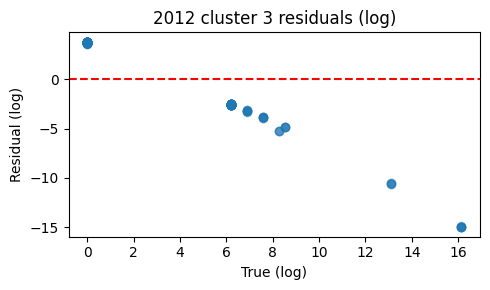

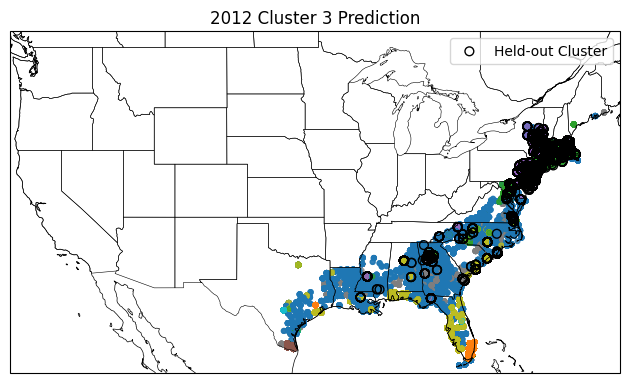

  → Evaluating cluster 5 in year 2012


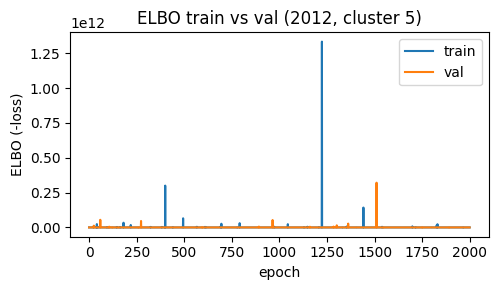

    Metrics (log space) → MAE=3.88, RMSE=4.40, R2=-0.07


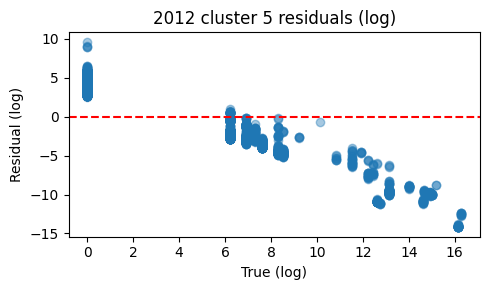

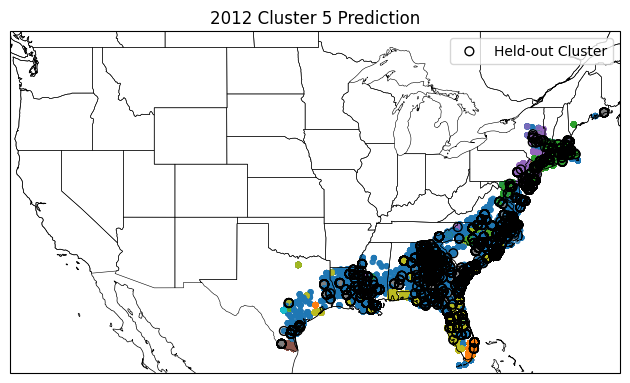

  → Evaluating cluster 6 in year 2012


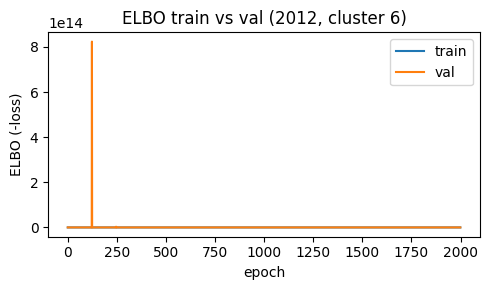

    Metrics (log space) → MAE=10.50, RMSE=11.66, R2=-2.01


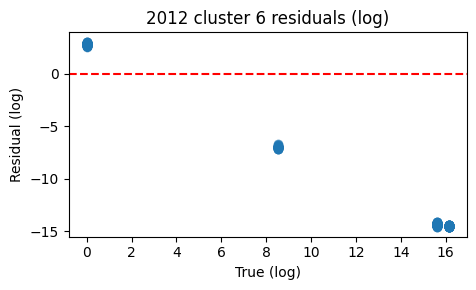

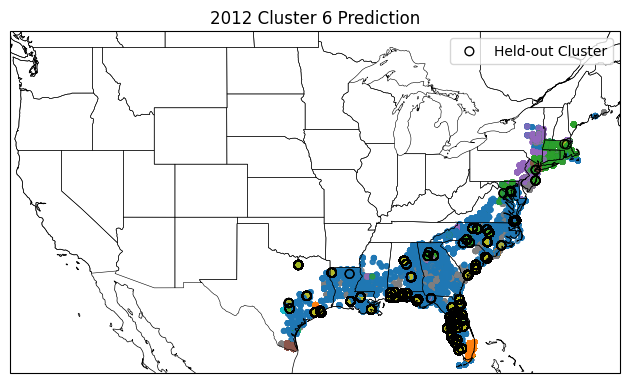

  → Evaluating cluster 7 in year 2012


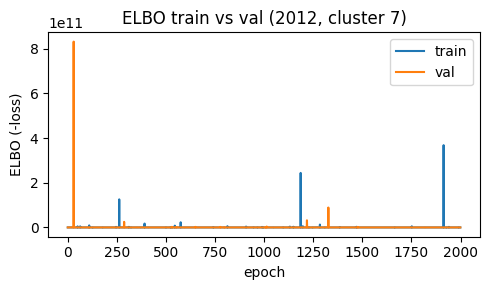

    Metrics (log space) → MAE=11.70, RMSE=11.71, R2=-392.68


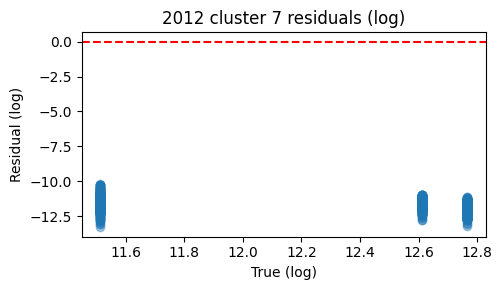

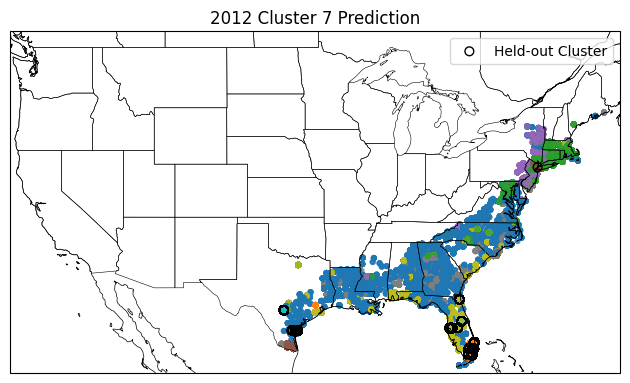


=== Leave-One-Year-Out Test: 2013 ===
  → Evaluating cluster 0 in year 2013


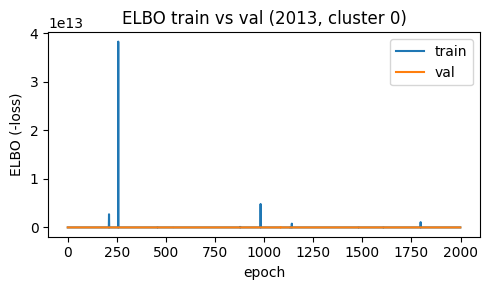

    Metrics (log space) → MAE=4.48, RMSE=4.61, R2=-2.52


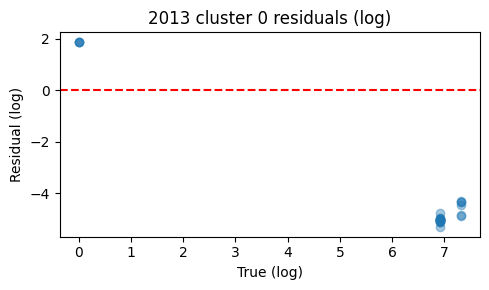

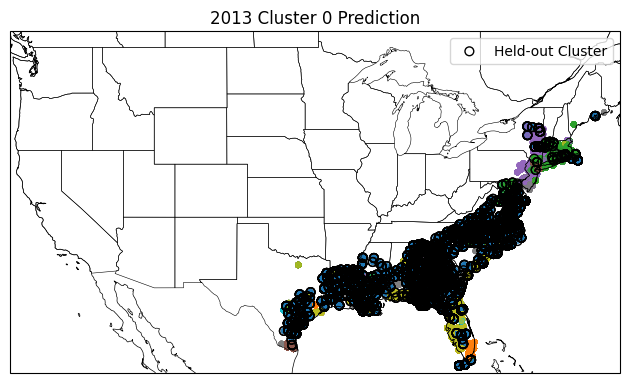

  → Evaluating cluster 2 in year 2013


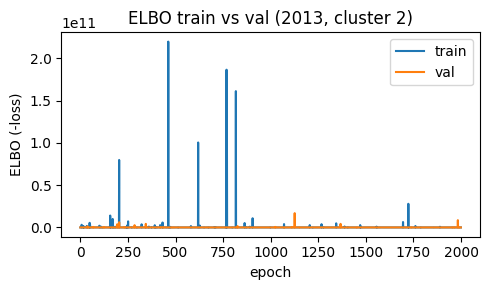

    Metrics (log space) → MAE=3.47, RMSE=3.47, R2=-0.14


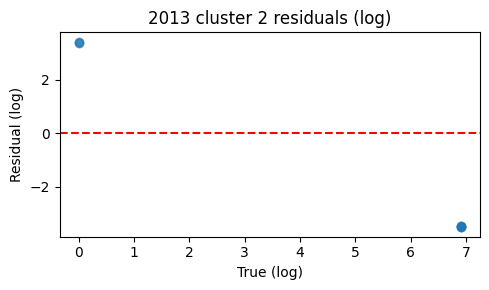

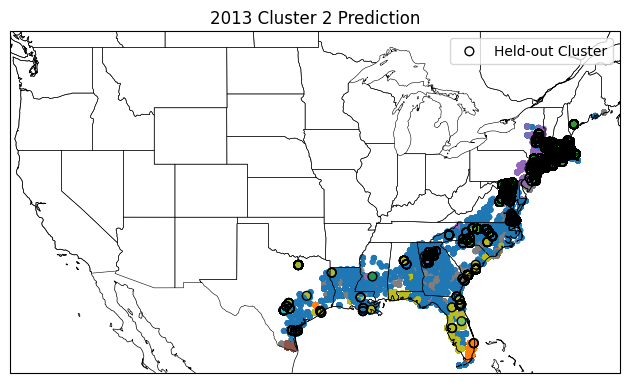

  → Evaluating cluster 3 in year 2013


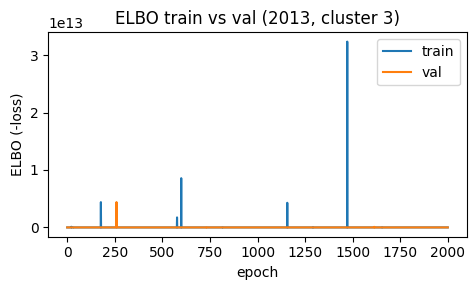

    Metrics (log space) → MAE=3.61, RMSE=3.74, R2=-0.16


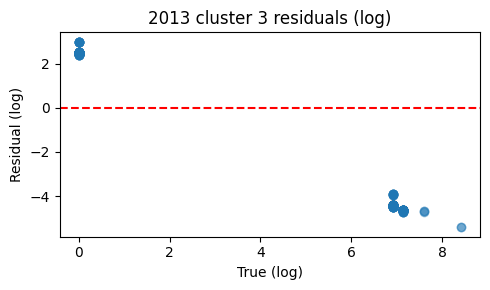

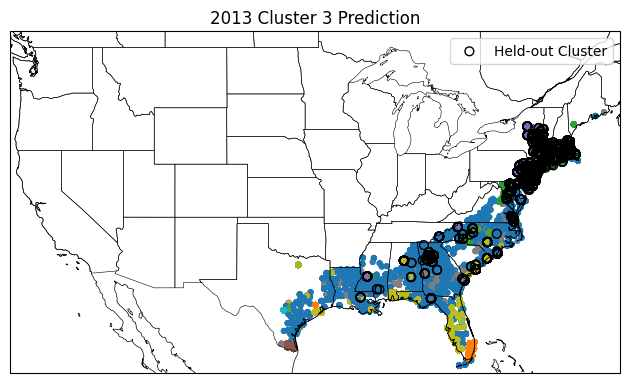

  → Evaluating cluster 5 in year 2013


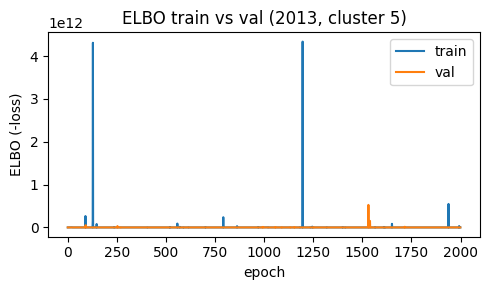

    Metrics (log space) → MAE=3.61, RMSE=3.82, R2=-0.17


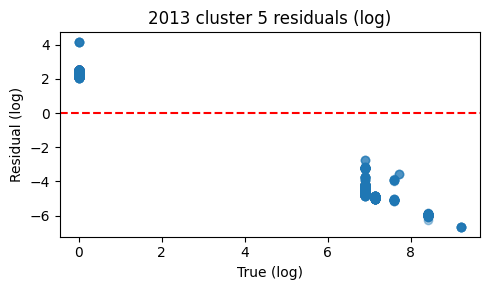

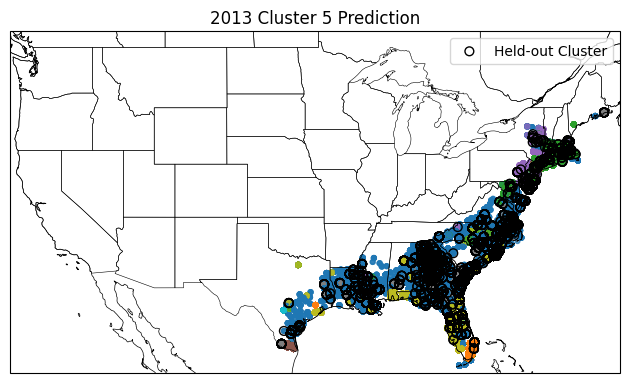

  → Evaluating cluster 6 in year 2013


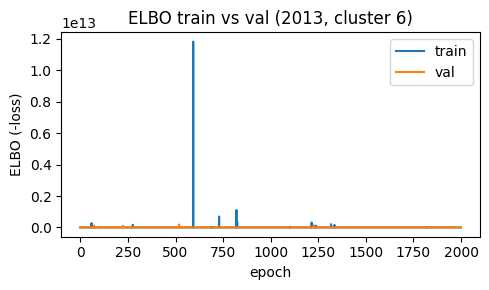

    Metrics (log space) → MAE=3.88, RMSE=4.06, R2=-0.55


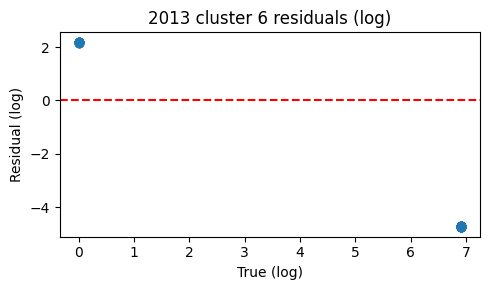

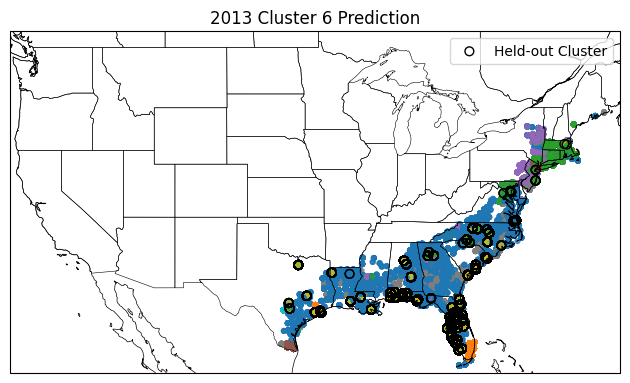


=== Leave-One-Year-Out Test: 2014 ===
  → Evaluating cluster 0 in year 2014


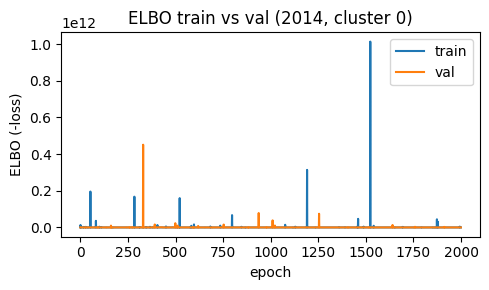

    Metrics (log space) → MAE=4.80, RMSE=4.84, R2=-0.19


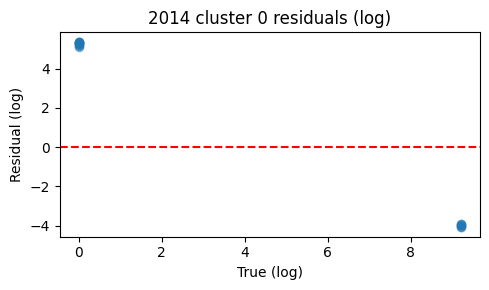

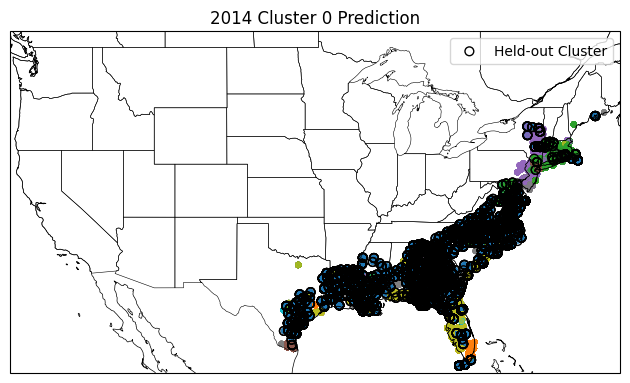

  → Evaluating cluster 2 in year 2014


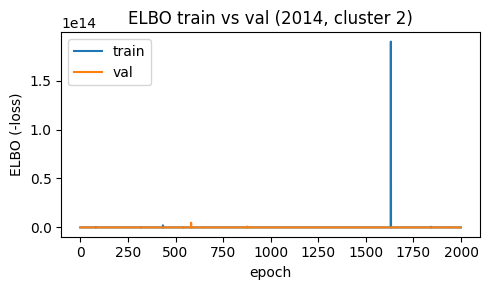

    Metrics (log space) → MAE=6.18, RMSE=6.22, R2=-12.70


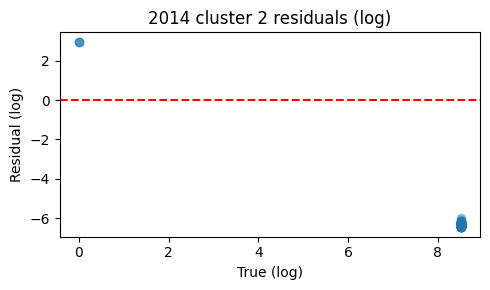

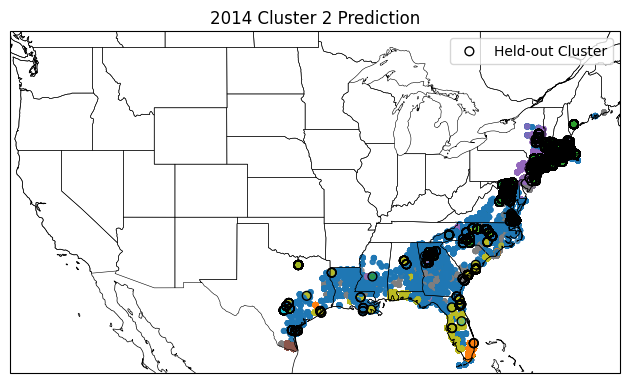

  → Evaluating cluster 3 in year 2014


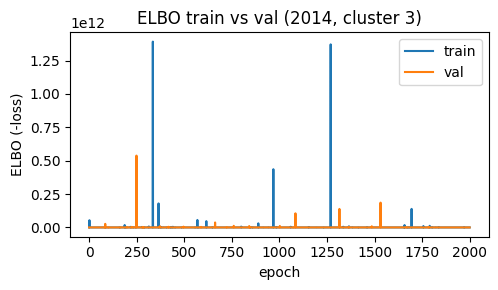

    Metrics (log space) → MAE=3.30, RMSE=3.33, R2=0.00


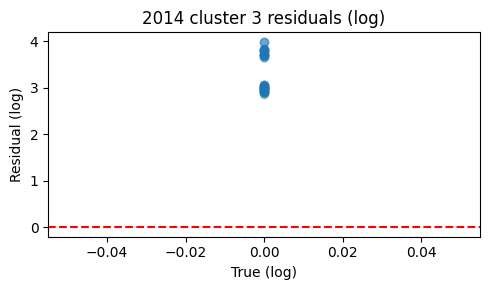

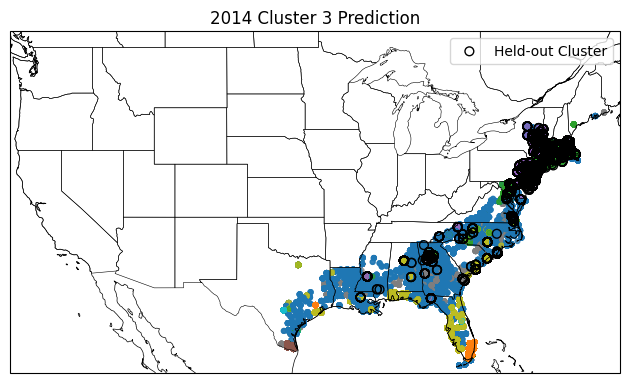

  → Evaluating cluster 5 in year 2014


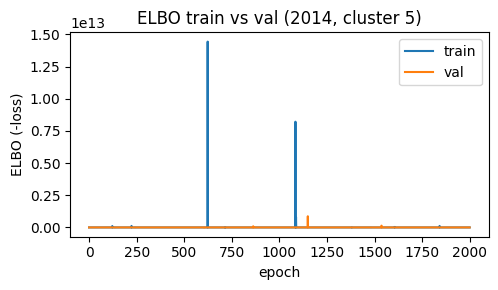

    Metrics (log space) → MAE=4.37, RMSE=4.43, R2=0.00


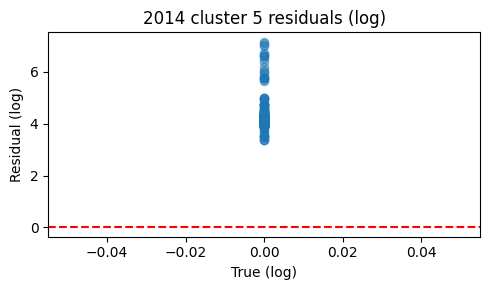

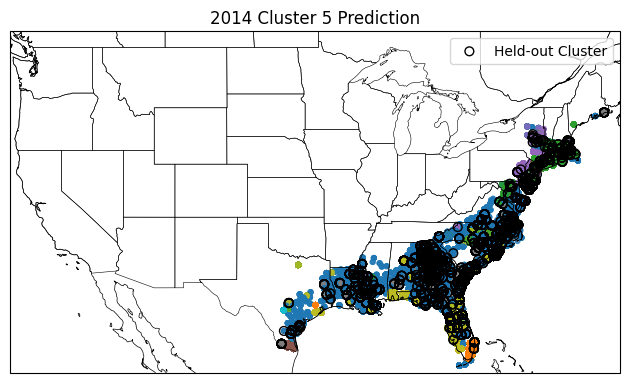

  → Evaluating cluster 6 in year 2014


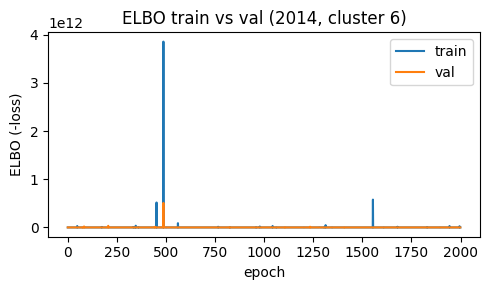

    Metrics (log space) → MAE=5.97, RMSE=5.97, R2=0.00


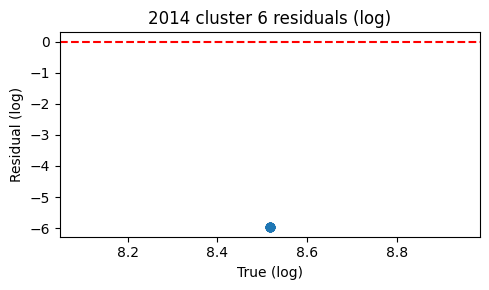

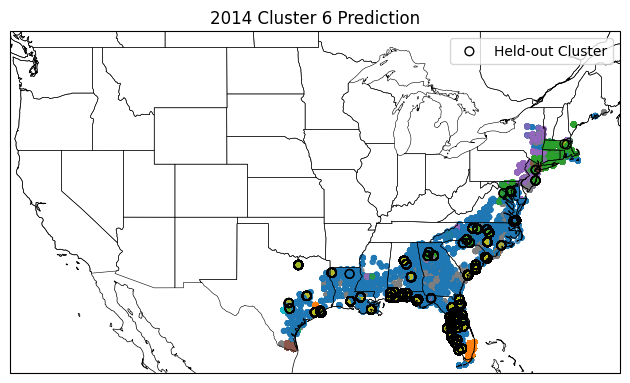


=== Leave-One-Year-Out Test: 2015 ===
  → Evaluating cluster 0 in year 2015


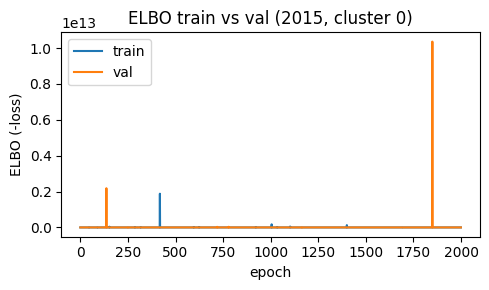

    Metrics (log space) → MAE=3.28, RMSE=3.32, R2=-0.22


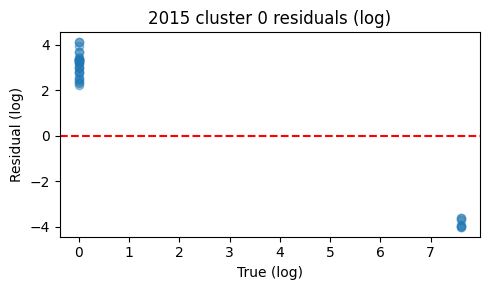

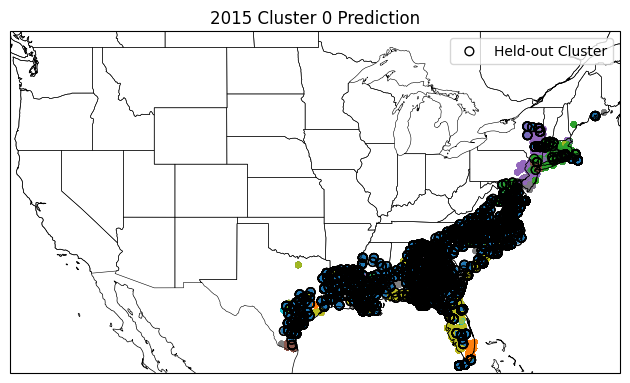

  → Evaluating cluster 2 in year 2015


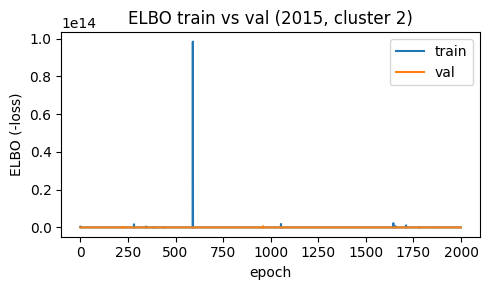

    Metrics (log space) → MAE=13.75, RMSE=13.75, R2=-207,911,263,404,032.00


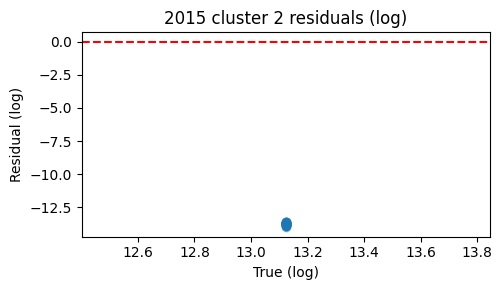

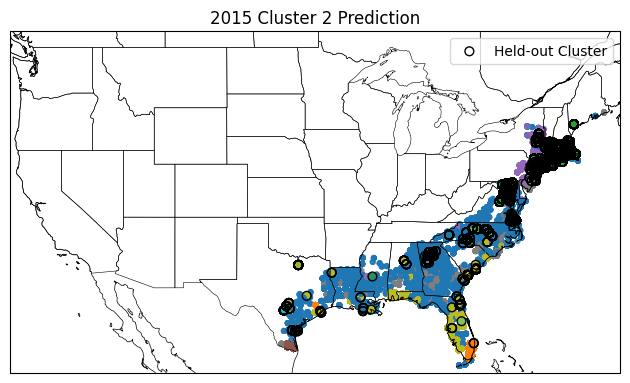

  → Evaluating cluster 6 in year 2015


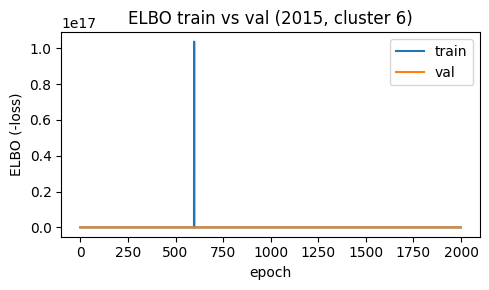

    Metrics (log space) → MAE=8.39, RMSE=10.01, R2=-1.64


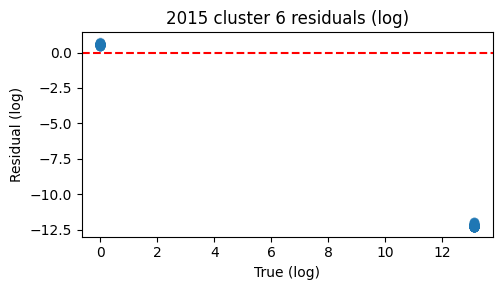

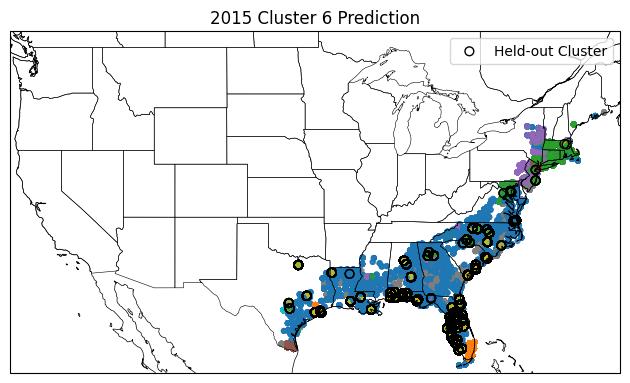


=== Leave-One-Year-Out Test: 2016 ===
  → Evaluating cluster 0 in year 2016


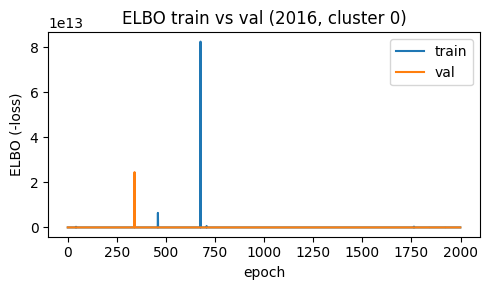

    Metrics (log space) → MAE=5.38, RMSE=7.12, R2=-0.24


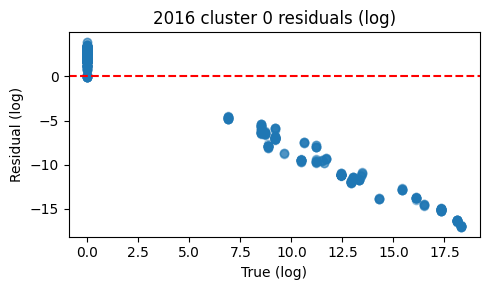

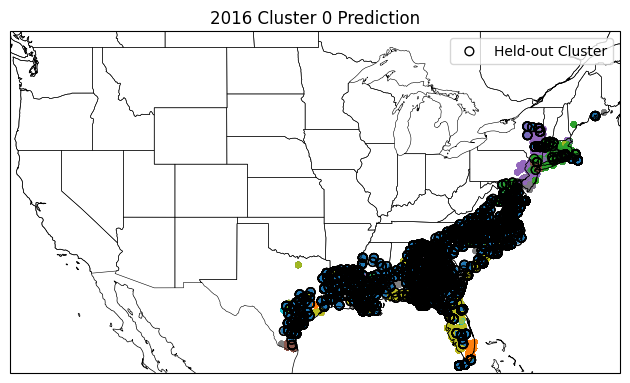

  → Evaluating cluster 2 in year 2016


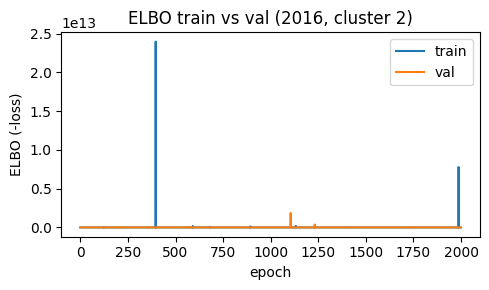

    Metrics (log space) → MAE=7.74, RMSE=8.30, R2=-3.11


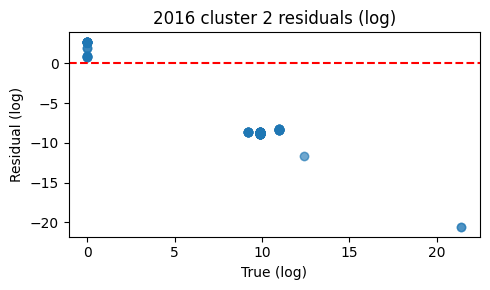

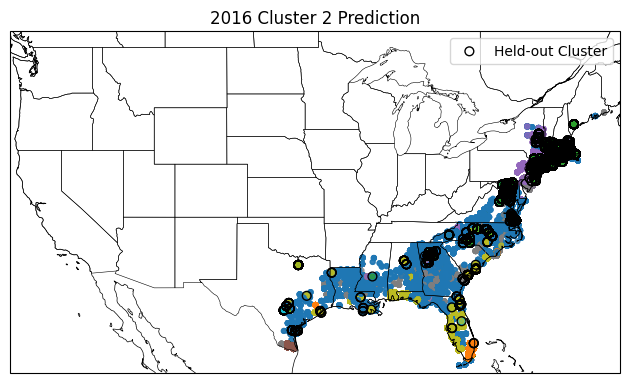

  → Evaluating cluster 3 in year 2016


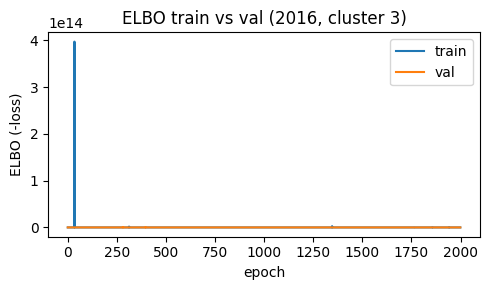

    Metrics (log space) → MAE=8.09, RMSE=9.24, R2=-2.21


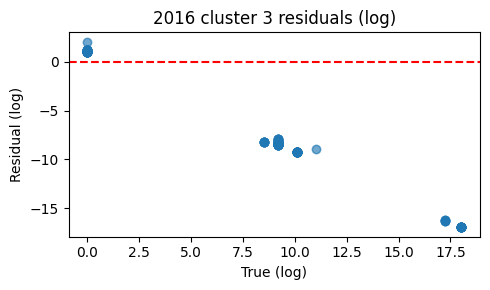

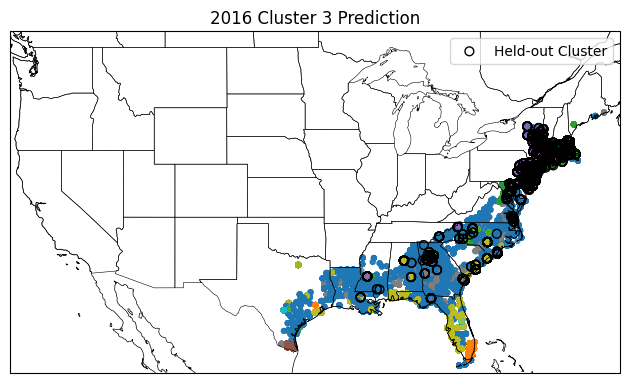

  → Evaluating cluster 5 in year 2016


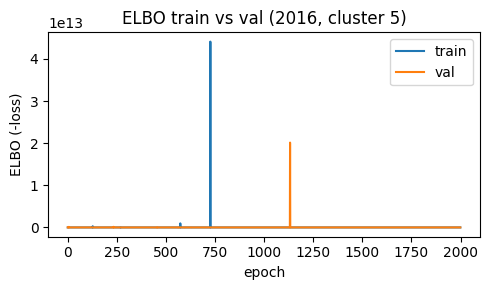

    Metrics (log space) → MAE=4.75, RMSE=6.67, R2=-0.22


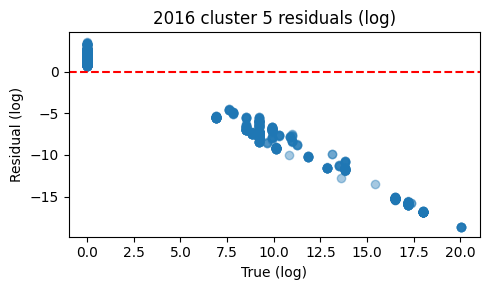

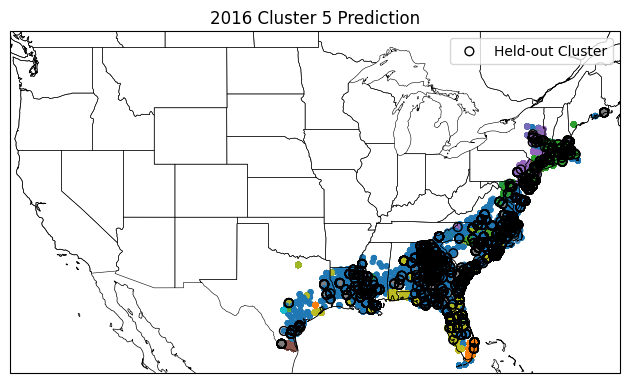

  → Evaluating cluster 6 in year 2016


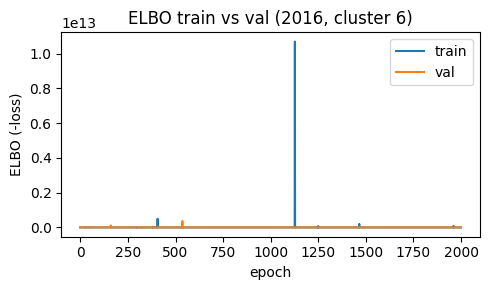

    Metrics (log space) → MAE=4.88, RMSE=7.07, R2=-0.37


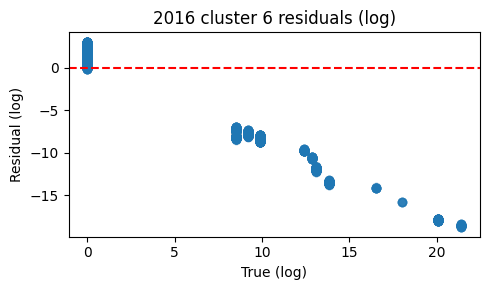

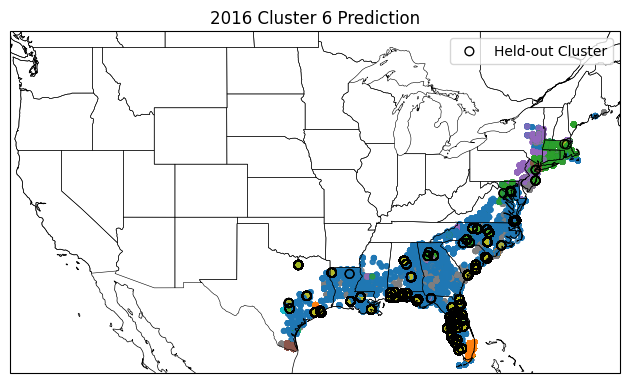

  → Evaluating cluster 7 in year 2016


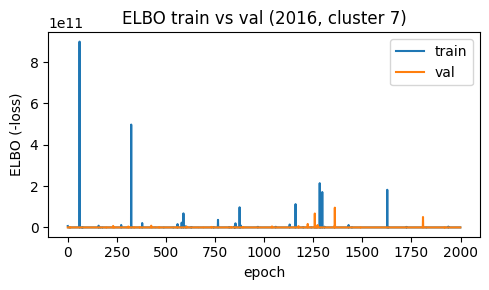

    Metrics (log space) → MAE=5.83, RMSE=8.46, R2=-0.76


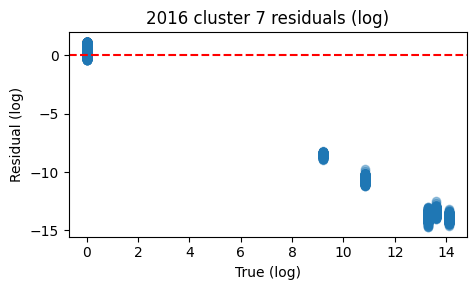

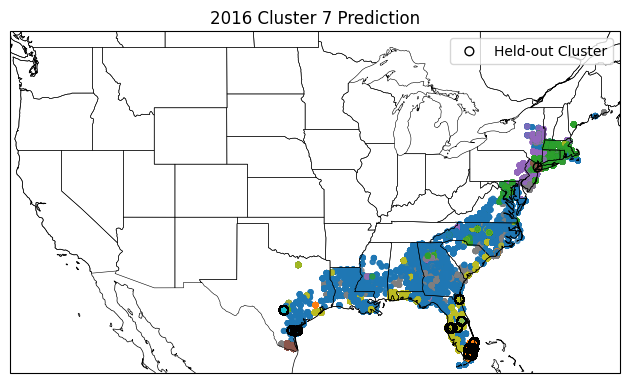


=== Leave-One-Year-Out Test: 2017 ===
  → Evaluating cluster 0 in year 2017


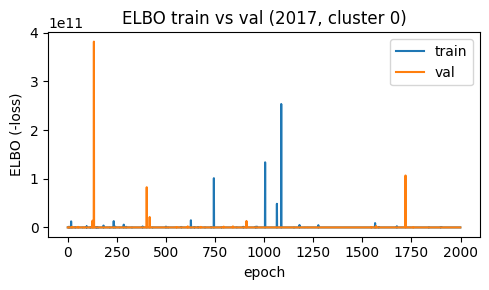

    Metrics (log space) → MAE=7.19, RMSE=8.09, R2=-0.85


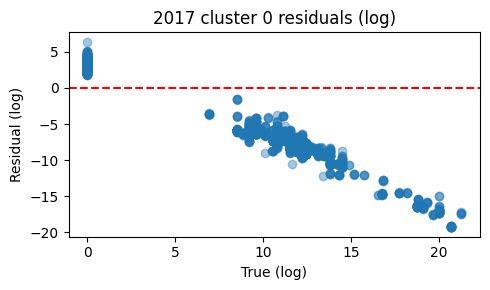

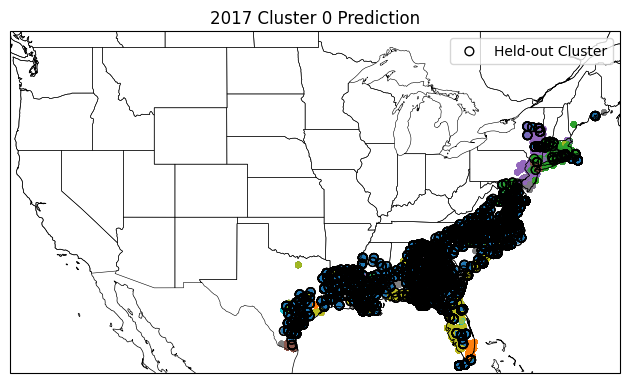

  → Evaluating cluster 1 in year 2017


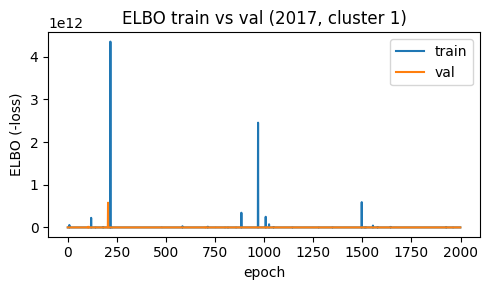

    Metrics (log space) → MAE=4.21, RMSE=6.82, R2=-0.44


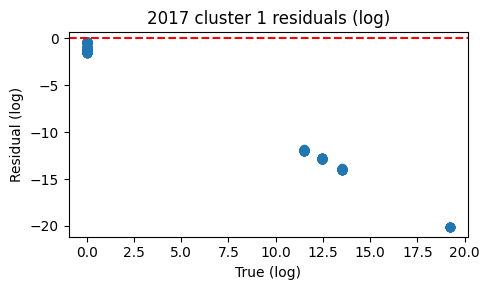

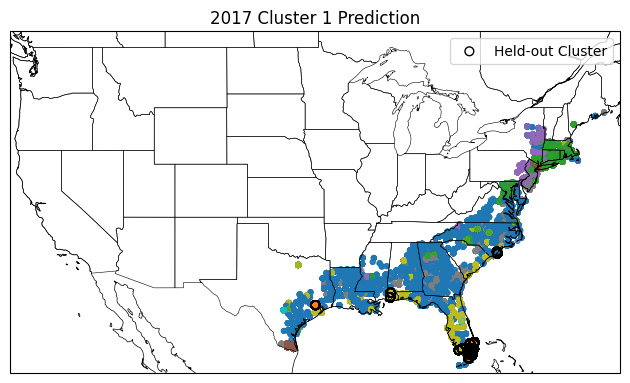

  → Evaluating cluster 2 in year 2017


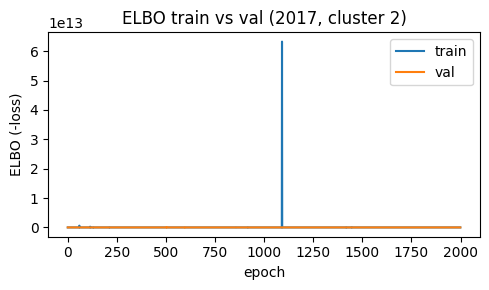

    Metrics (log space) → MAE=7.57, RMSE=7.81, R2=-13.40


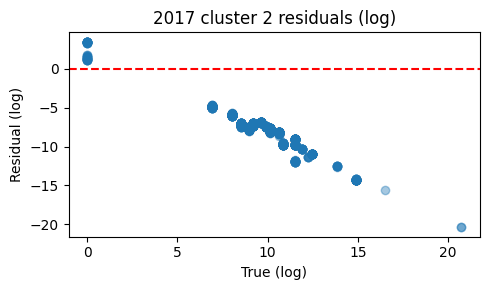

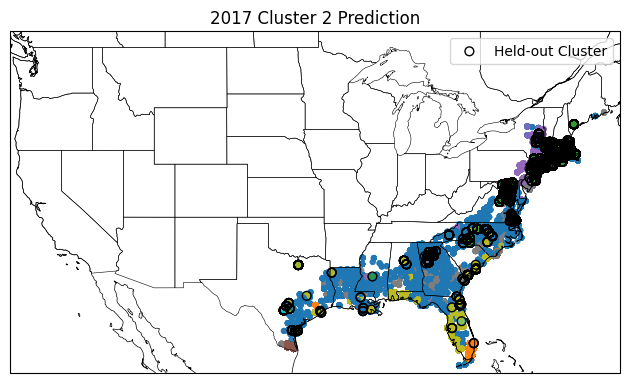

  → Evaluating cluster 3 in year 2017


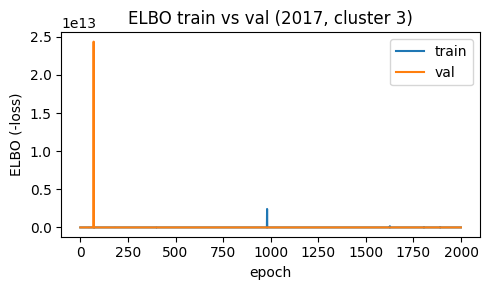

    Metrics (log space) → MAE=7.49, RMSE=8.29, R2=-2.89


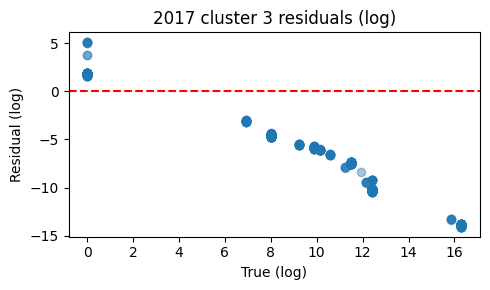

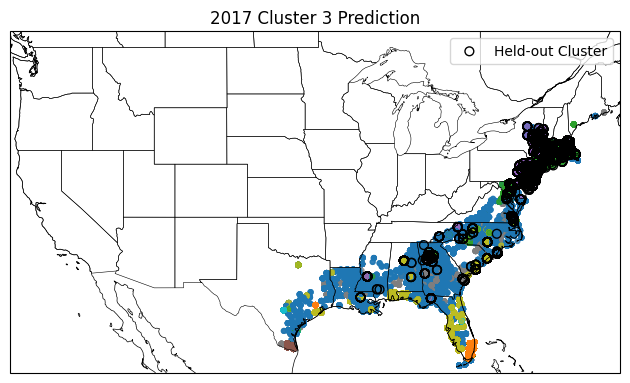

  → Evaluating cluster 5 in year 2017


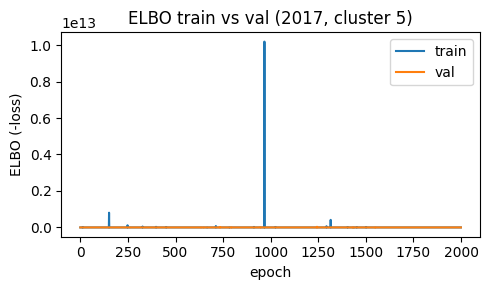

    Metrics (log space) → MAE=9.71, RMSE=10.71, R2=-2.42


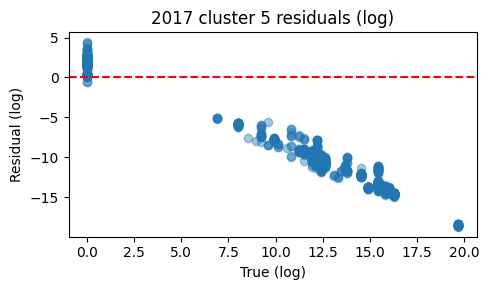

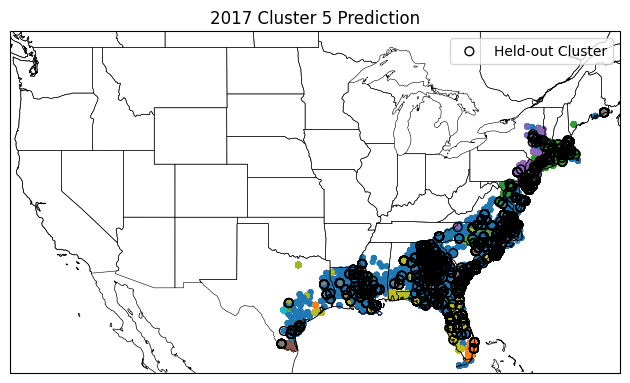

  → Evaluating cluster 6 in year 2017


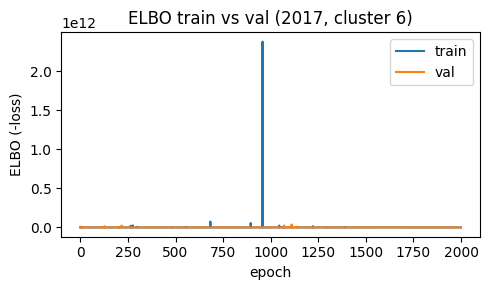

    Metrics (log space) → MAE=10.39, RMSE=12.58, R2=-1.45


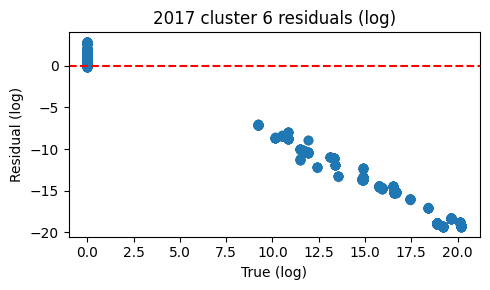

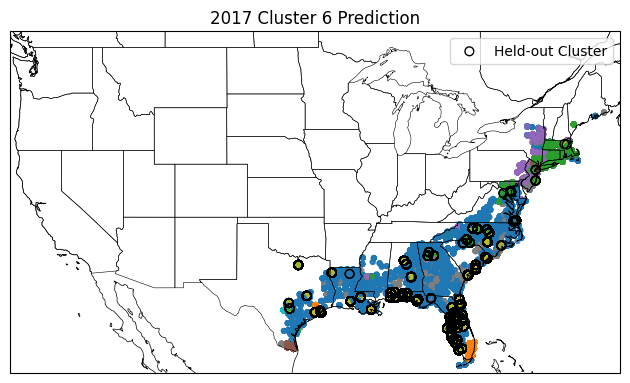

  → Evaluating cluster 7 in year 2017


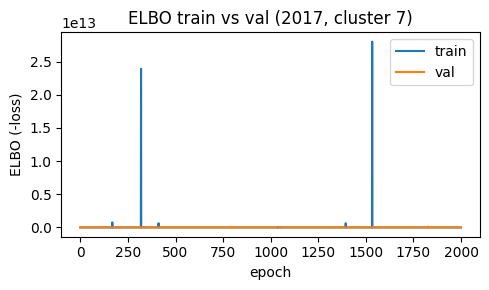

    Metrics (log space) → MAE=11.72, RMSE=13.89, R2=-2.23


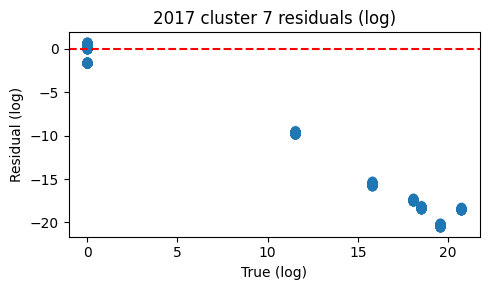

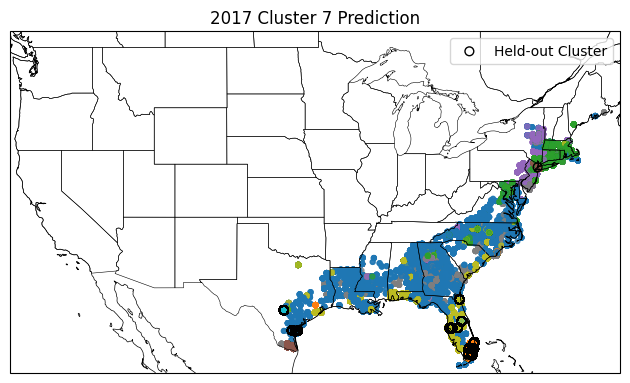


=== Leave-One-Year-Out Test: 2018 ===
  → Evaluating cluster 0 in year 2018


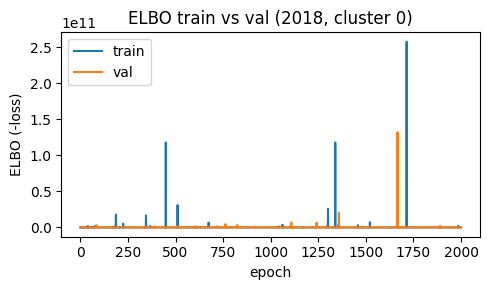

    Metrics (log space) → MAE=8.36, RMSE=9.50, R2=-1.41


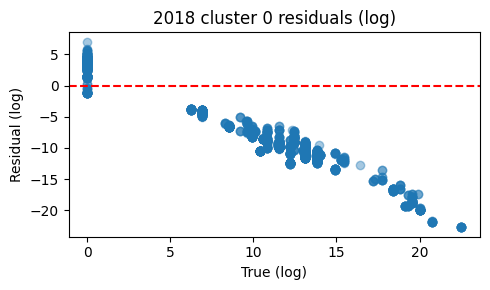

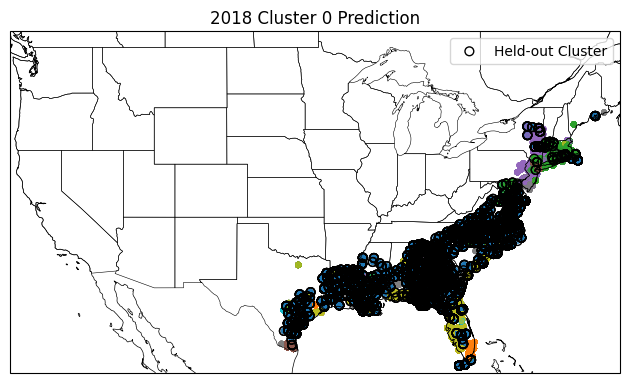

  → Evaluating cluster 1 in year 2018


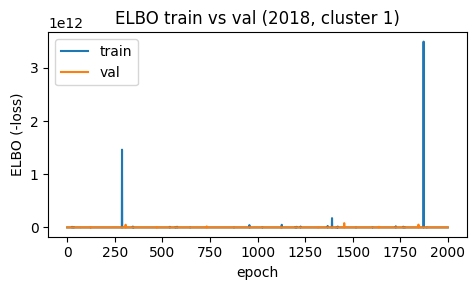

    Metrics (log space) → MAE=7.13, RMSE=12.03, R2=-0.52


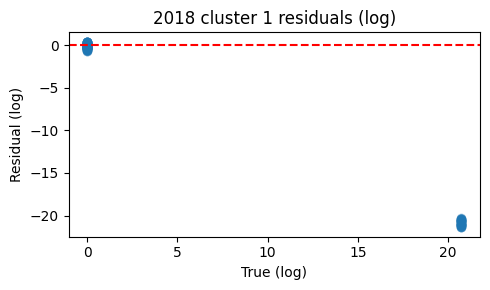

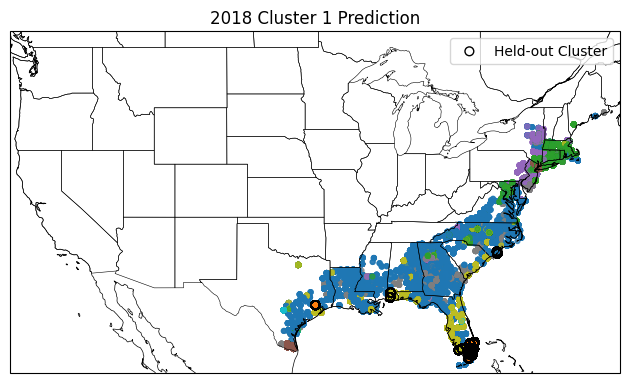

  → Evaluating cluster 2 in year 2018


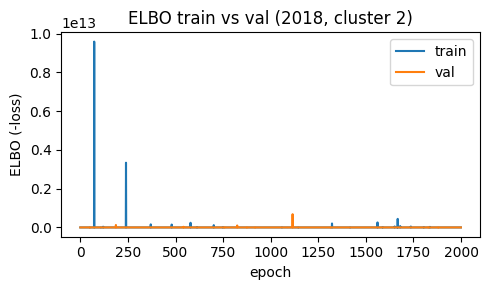

    Metrics (log space) → MAE=11.18, RMSE=11.70, R2=-10.94


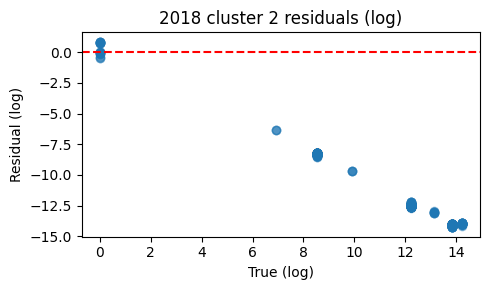

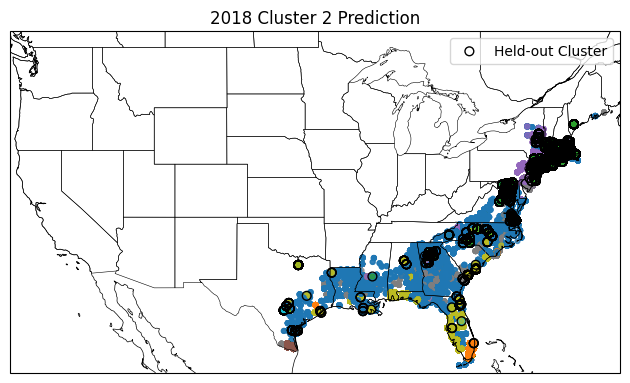

  → Evaluating cluster 3 in year 2018


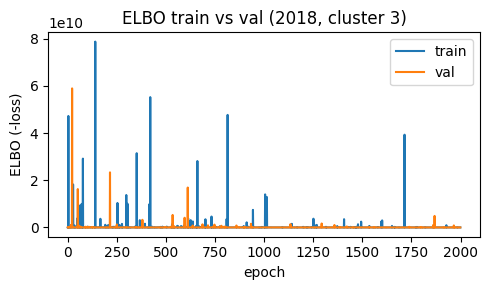

    Metrics (log space) → MAE=11.68, RMSE=12.55, R2=-5.42


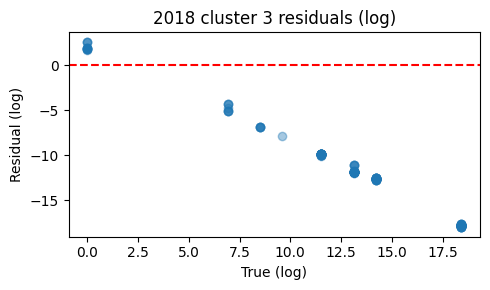

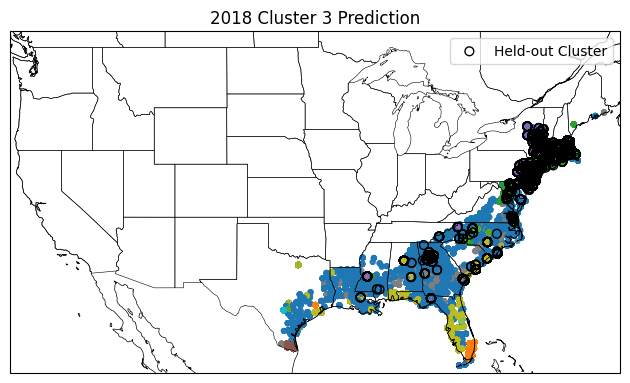

  → Evaluating cluster 5 in year 2018


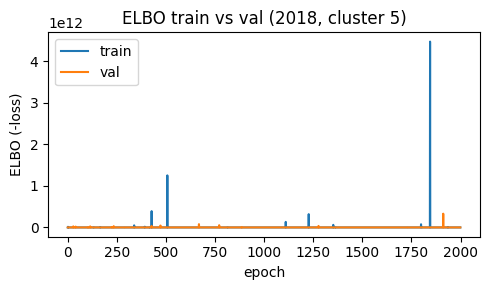

    Metrics (log space) → MAE=7.10, RMSE=8.57, R2=-0.24


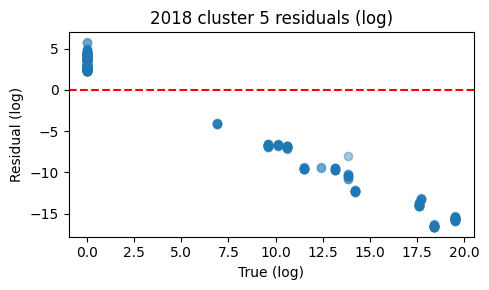

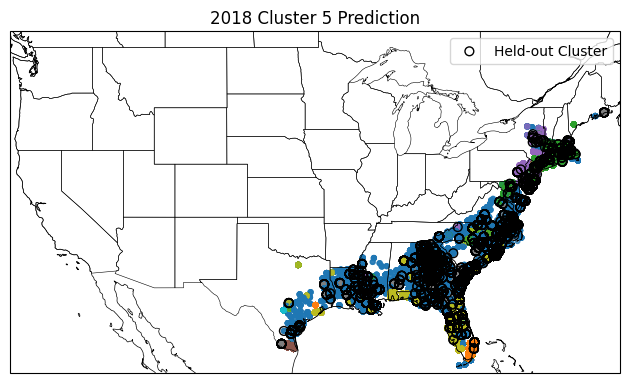

  → Evaluating cluster 6 in year 2018


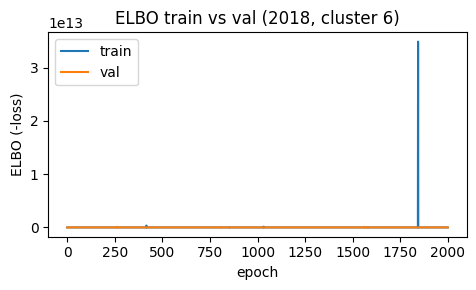

    Metrics (log space) → MAE=7.53, RMSE=9.28, R2=-1.19


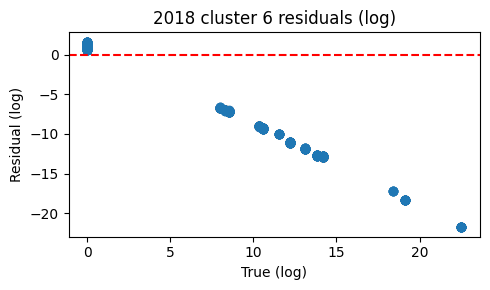

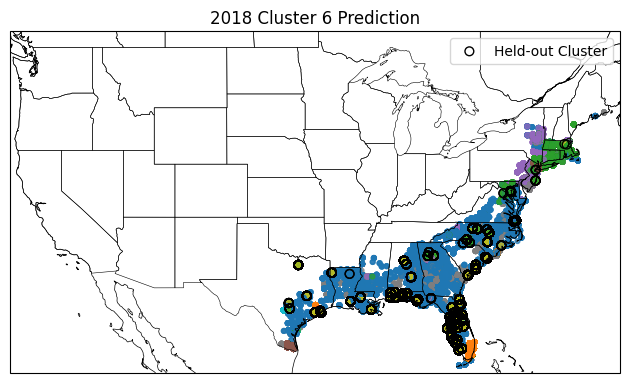

  → Evaluating cluster 7 in year 2018


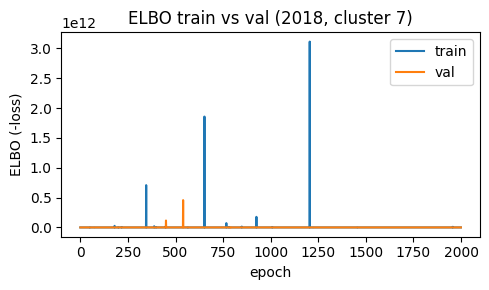

    Metrics (log space) → MAE=0.60, RMSE=0.70, R2=0.00


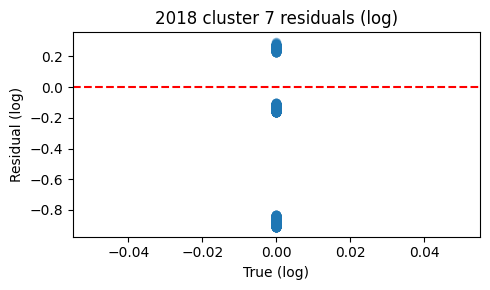

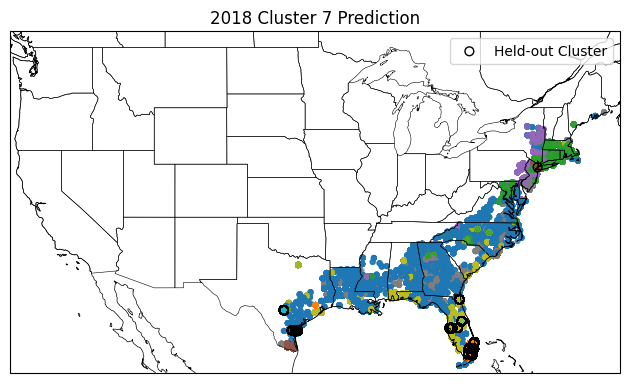


=== Leave-One-Year-Out Test: 2019 ===
  → Evaluating cluster 0 in year 2019


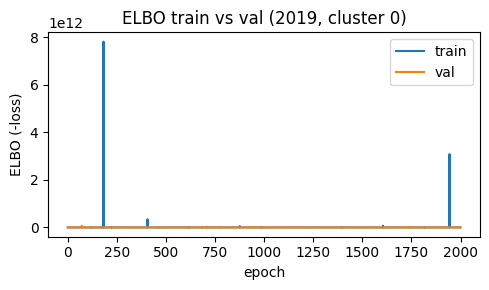

    Metrics (log space) → MAE=5.43, RMSE=6.18, R2=-0.34


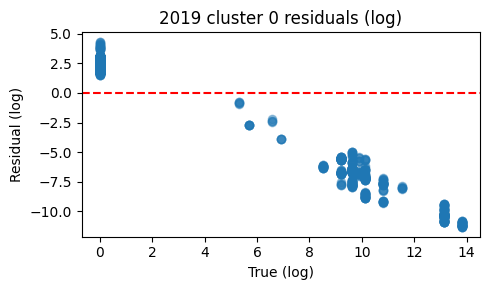

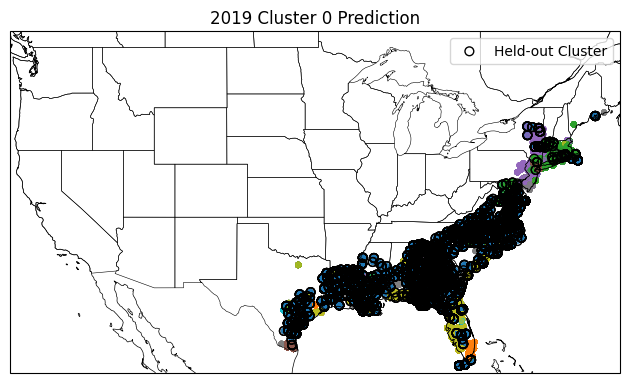

  → Evaluating cluster 1 in year 2019


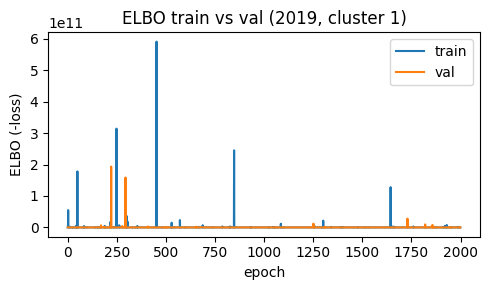

    Metrics (log space) → MAE=2.99, RMSE=2.99, R2=0.00


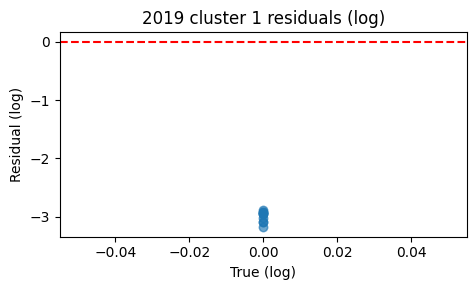

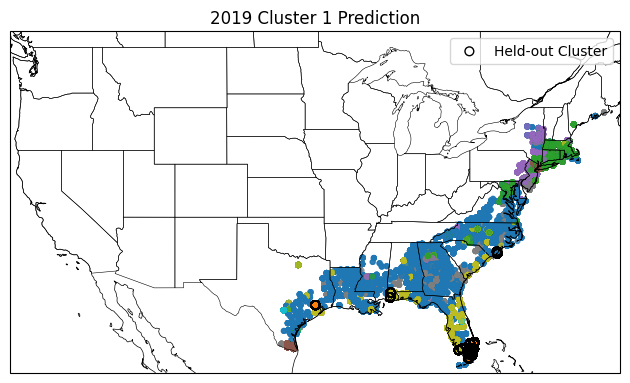

  → Evaluating cluster 2 in year 2019


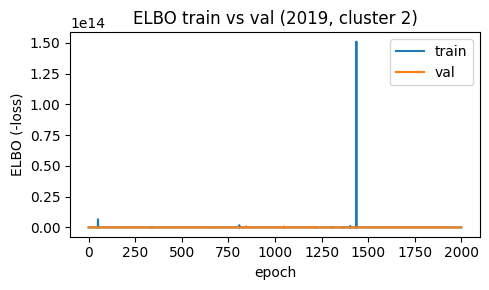

    Metrics (log space) → MAE=5.68, RMSE=5.97, R2=-9.74


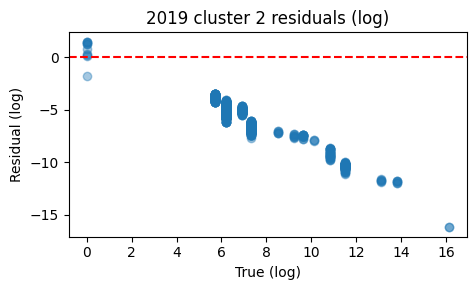

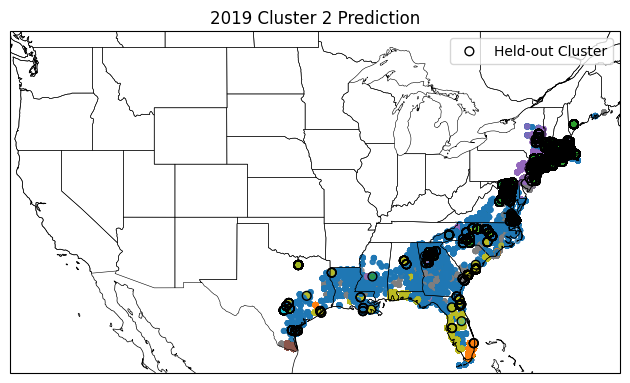

  → Evaluating cluster 3 in year 2019


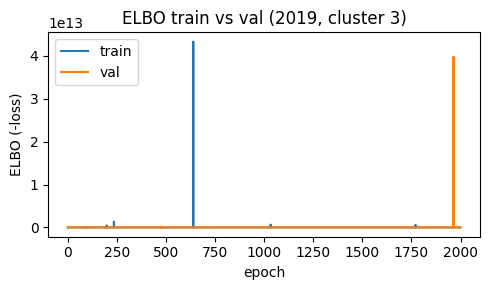

    Metrics (log space) → MAE=7.03, RMSE=7.30, R2=-9.13


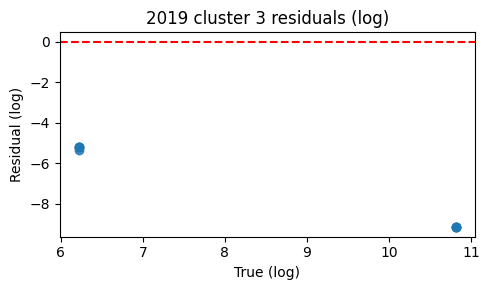

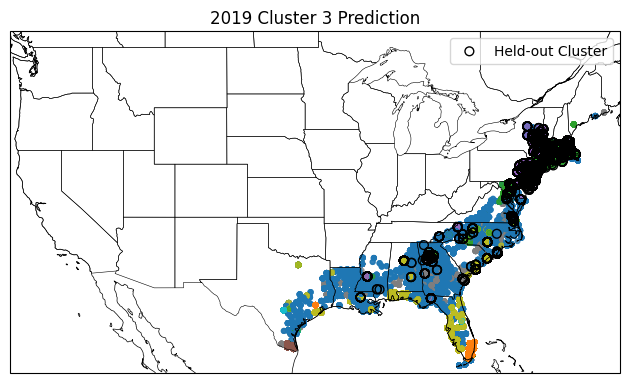

  → Evaluating cluster 5 in year 2019


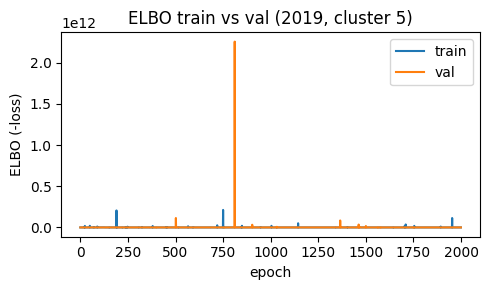

    Metrics (log space) → MAE=7.52, RMSE=7.96, R2=-1.79


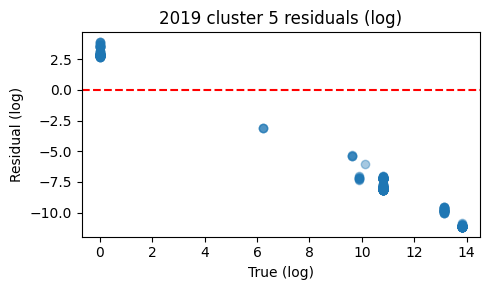

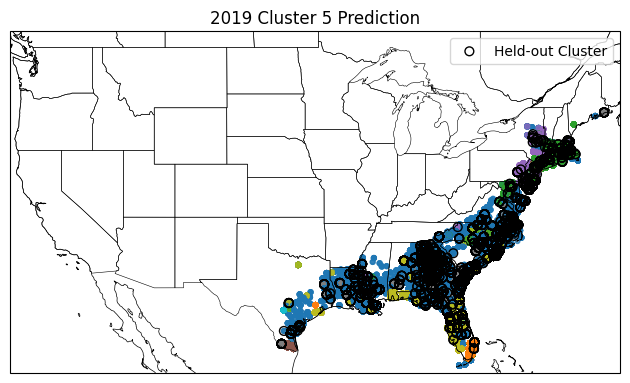

  → Evaluating cluster 6 in year 2019


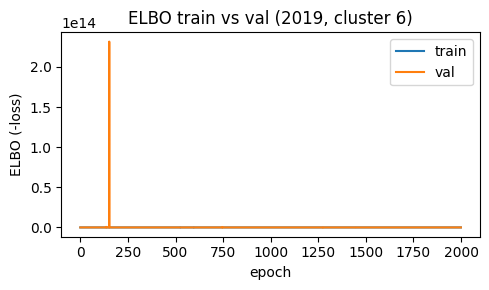

    Metrics (log space) → MAE=4.93, RMSE=7.65, R2=-0.25


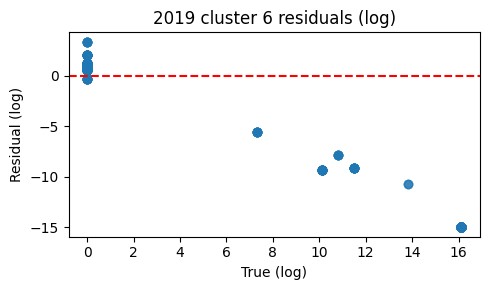

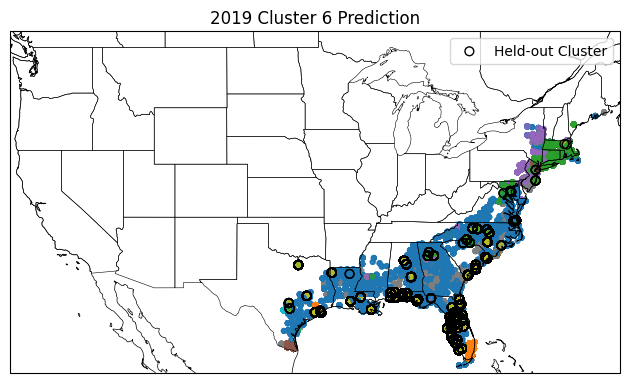

  → Evaluating cluster 7 in year 2019


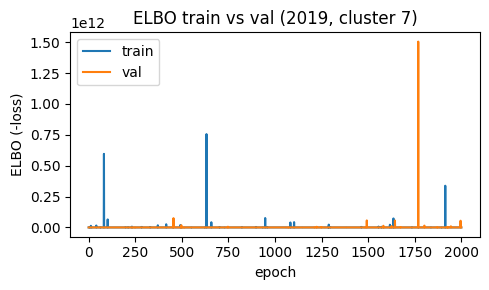

    Metrics (log space) → MAE=1.84, RMSE=1.93, R2=0.00


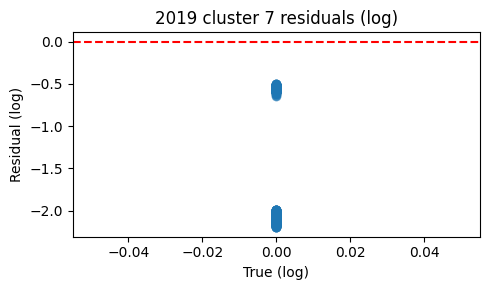

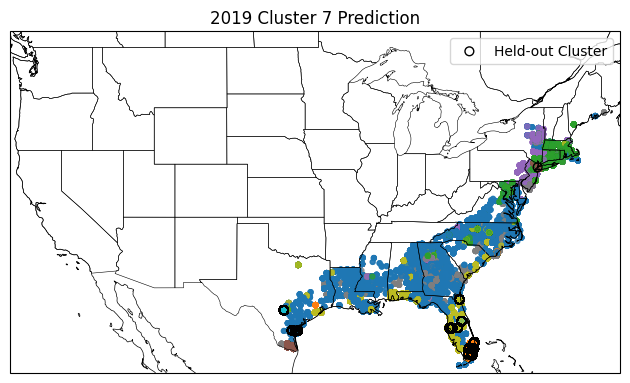


=== Leave-One-Year-Out Test: 2020 ===
  → Evaluating cluster 0 in year 2020


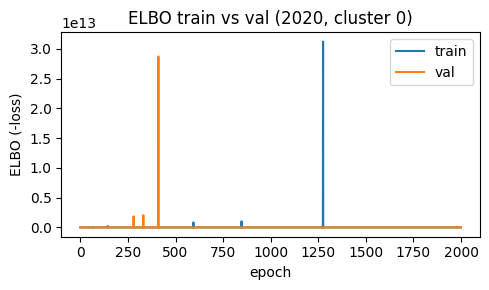

    Metrics (log space) → MAE=7.40, RMSE=9.20, R2=-0.91


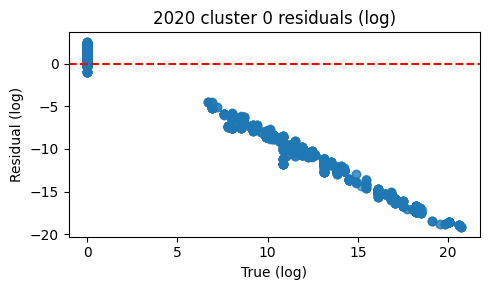

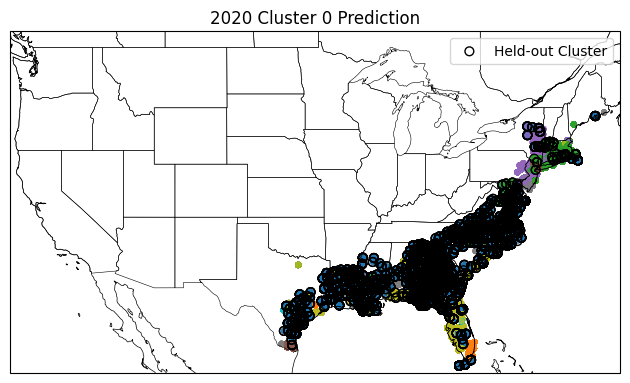

  → Evaluating cluster 1 in year 2020


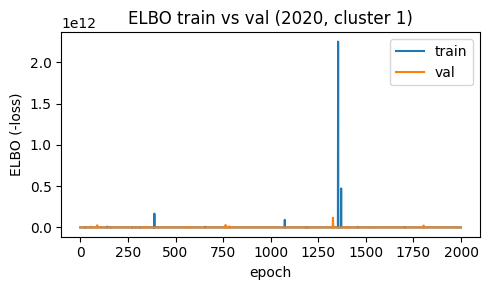

    Metrics (log space) → MAE=0.70, RMSE=0.89, R2=0.00


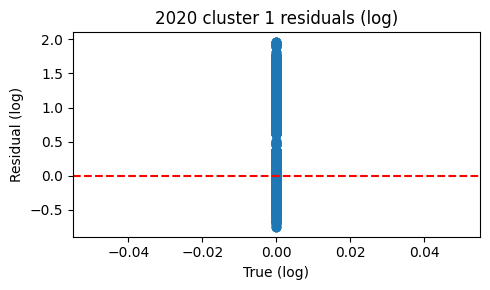

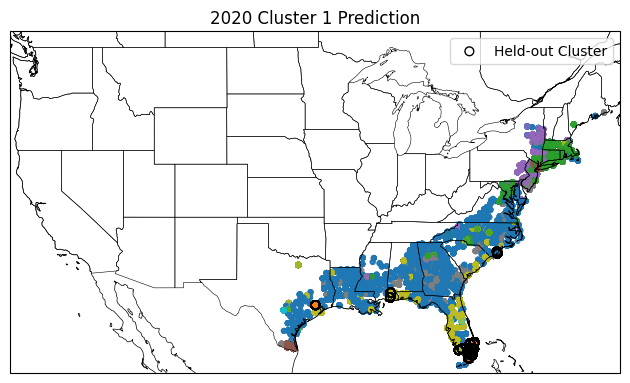

  → Evaluating cluster 2 in year 2020


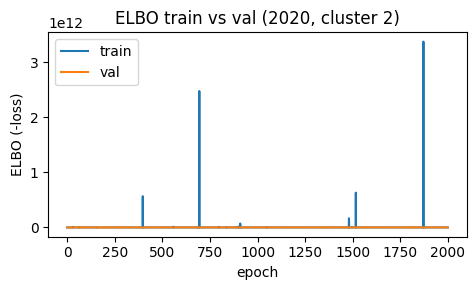

    Metrics (log space) → MAE=5.59, RMSE=7.20, R2=-0.41


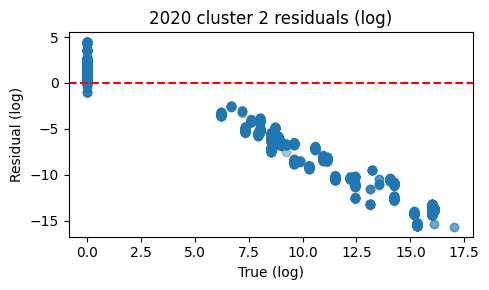

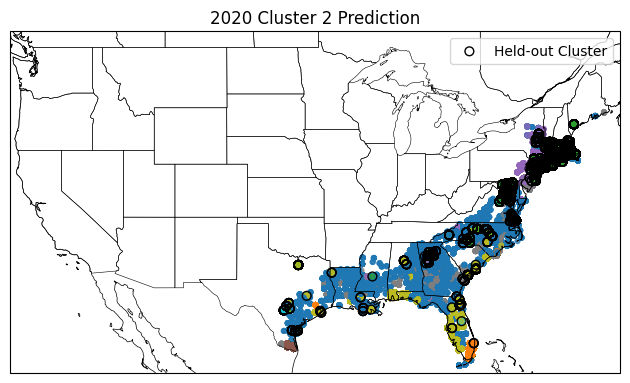

  → Evaluating cluster 3 in year 2020


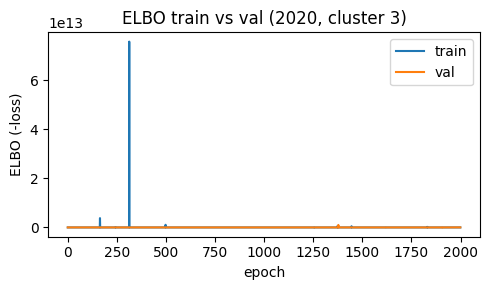

    Metrics (log space) → MAE=4.82, RMSE=7.56, R2=-0.36


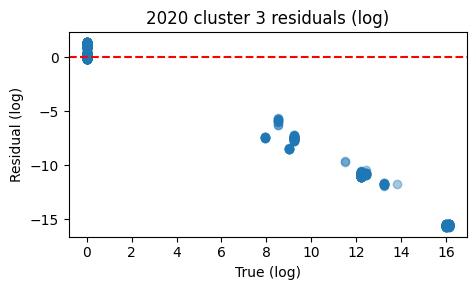

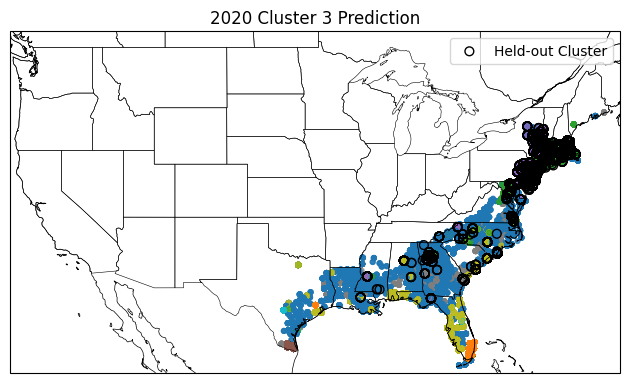

  → Evaluating cluster 4 in year 2020


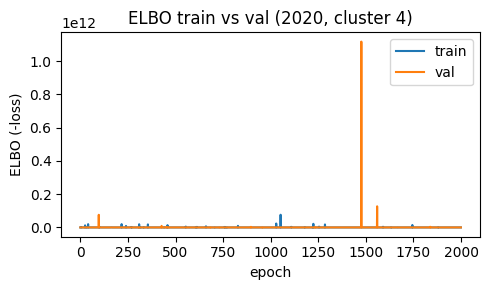

    Metrics (log space) → MAE=10.47, RMSE=13.88, R2=-1.81


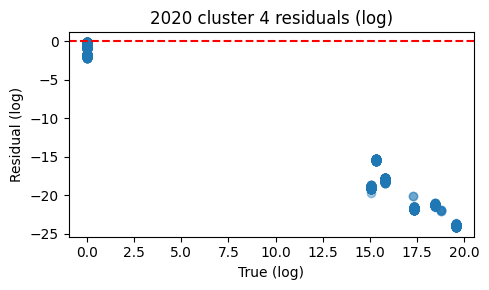

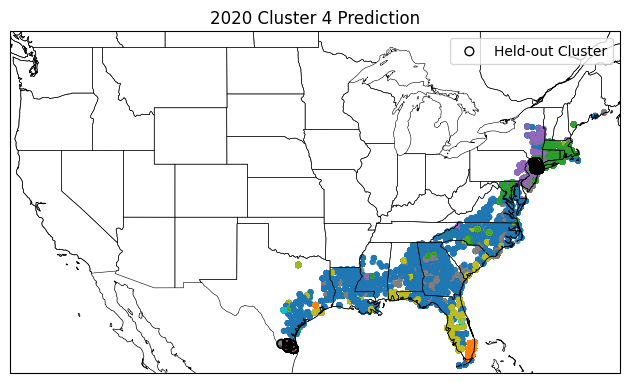

  → Evaluating cluster 5 in year 2020


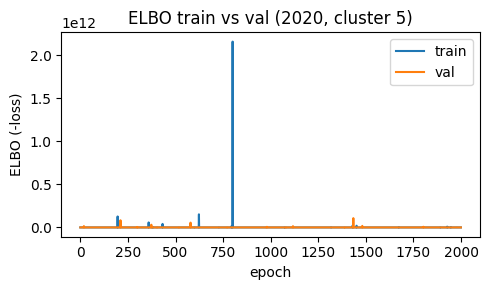

    Metrics (log space) → MAE=7.22, RMSE=8.97, R2=-0.91


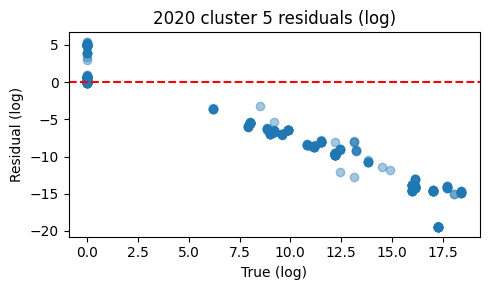

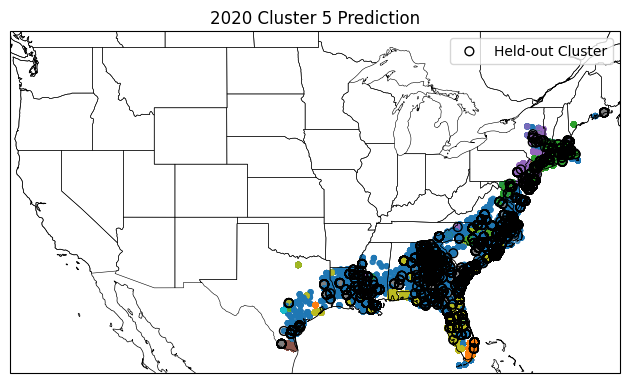

  → Evaluating cluster 6 in year 2020


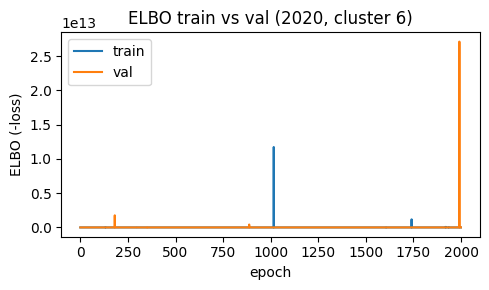

    Metrics (log space) → MAE=4.28, RMSE=6.95, R2=-0.13


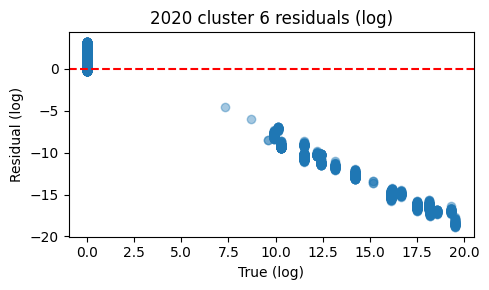

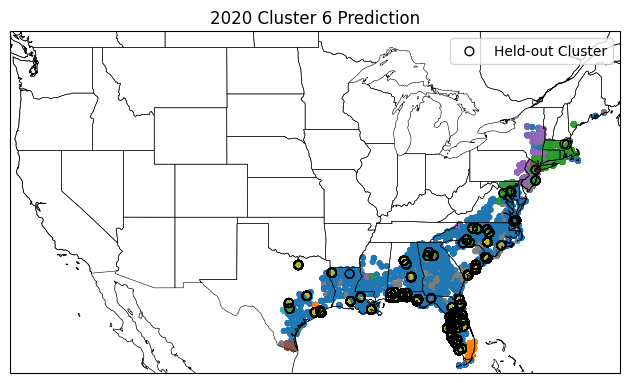

  → Evaluating cluster 7 in year 2020


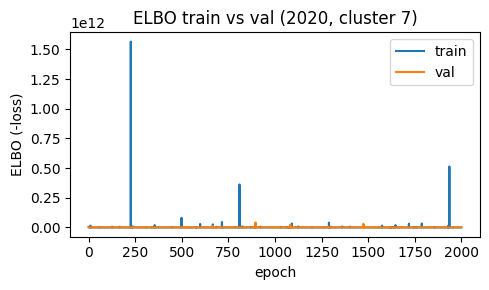

    Metrics (log space) → MAE=8.31, RMSE=9.90, R2=-1.69


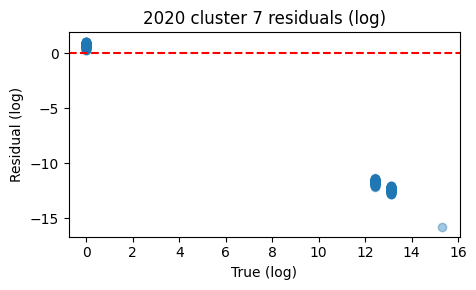

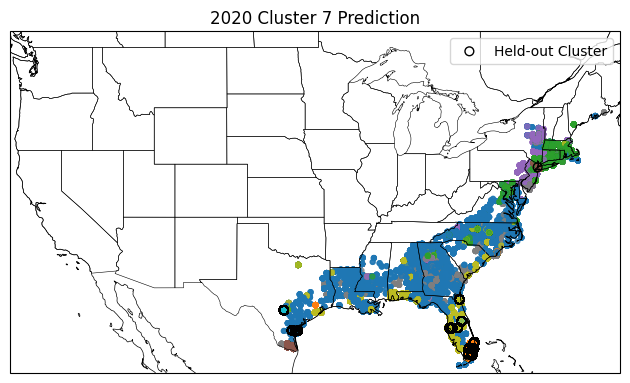

In [5]:
# ──────────────────────────── MAIN ────────────────────────────
df_all = pd.read_csv(DATA_FILE)
print(f"Loaded cleaned data → {len(df_all)} rows")

# KMeans clustering on scaled FEATURES for spatial splits (Model M7)
scaler_features = StandardScaler().fit(df_all[FEATURES])
scaled_feats = scaler_features.transform(df_all[FEATURES])
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=SEED)
df_all["cluster"] = kmeans.fit_predict(scaled_feats)
if SHOW_MAPS:
    plot_clusters_map(df_all, title="M7 Clusters: KMeans on Scaled Features")

yearly_metrics = []
prediction_logs = []

for test_year in range(2010, 2021):
    print(f"\n=== Leave-One-Year-Out Test: {test_year} ===")
    year_train = df_all[df_all["Year"] != test_year].copy()
    year_test  = df_all[df_all["Year"] == test_year].copy()

    for cluster_id in sorted(year_test["cluster"].unique()):
        print(f"  → Evaluating cluster {cluster_id} in year {test_year}")
        cluster_test = year_test[year_test["cluster"] == cluster_id].copy()
        cluster_train = year_train.copy()

        tr_df, val_df = train_test_split(cluster_train, test_size=0.15, random_state=SEED)
        Xtr, ytr, scaler = tensors_from_df(tr_df)
        Xval, yval, _    = tensors_from_df(val_df, scaler)

        tr_elbo, val_elbo = train_svi(Xtr, ytr, Xval, yval)
        plot_elbo(tr_elbo, val_elbo, f"ELBO train vs val ({test_year}, cluster {cluster_id})")

        y_hat_log, y_true_log = predict(cluster_test, scaler)
        test_metrics  = compute_metrics(y_true_log, y_hat_log)
        test_metrics.update({"Year": test_year, "Cluster": cluster_id})
        yearly_metrics.append(test_metrics)

        pred_df = cluster_test.copy()
        pred_df["Predicted_log"] = y_hat_log
        pred_df["Actual_log"] = y_true_log
        prediction_logs.append(pred_df)

        print(f"    Metrics (log space) → " + ", ".join([f"{k}={v:,.2f}" for k,v in test_metrics.items() if k not in ["Year", "Cluster"]]))
        plot_residuals(y_true_log, y_hat_log, f"{test_year} cluster {cluster_id} residuals (log)")
        if SHOW_MAPS:
            plot_clusters_map(df_all, held_cluster=cluster_id, title=f"{test_year} Cluster {cluster_id} Prediction")




In [6]:
# ──────────────────────────── SUMMARY ────────────────────────────
summary_df = pd.DataFrame(yearly_metrics)
print("\nYearly Cluster Test Summary (log space):")
print(summary_df.groupby(["Year", "Cluster"]).mean().round(2))
summary_df.to_csv("M7_leave_one_year_one_cluster_summary_logspace.csv", index=False)

predictions_all = pd.concat(prediction_logs, ignore_index=True)
predictions_all.to_csv("M7_all_predictions_by_year_and_cluster_logspace.csv", index=False)
print("\nSaved all predictions and summary (log space) to disk.")


Yearly Cluster Test Summary (log space):
                MAE   RMSE     R2
Year Cluster                     
2010 0         5.29   6.01  -0.27
     2         1.47   1.77  -0.82
     3         4.04   4.04   0.00
     4        13.46  13.66 -34.22
     5         4.70   5.16  -0.23
...             ...    ...    ...
2020 3         4.82   7.56  -0.36
     4        10.47  13.88  -1.81
     5         7.22   8.97  -0.91
     6         4.28   6.95  -0.13
     7         8.31   9.90  -1.69

[67 rows x 3 columns]

Saved all predictions and summary (log space) to disk.


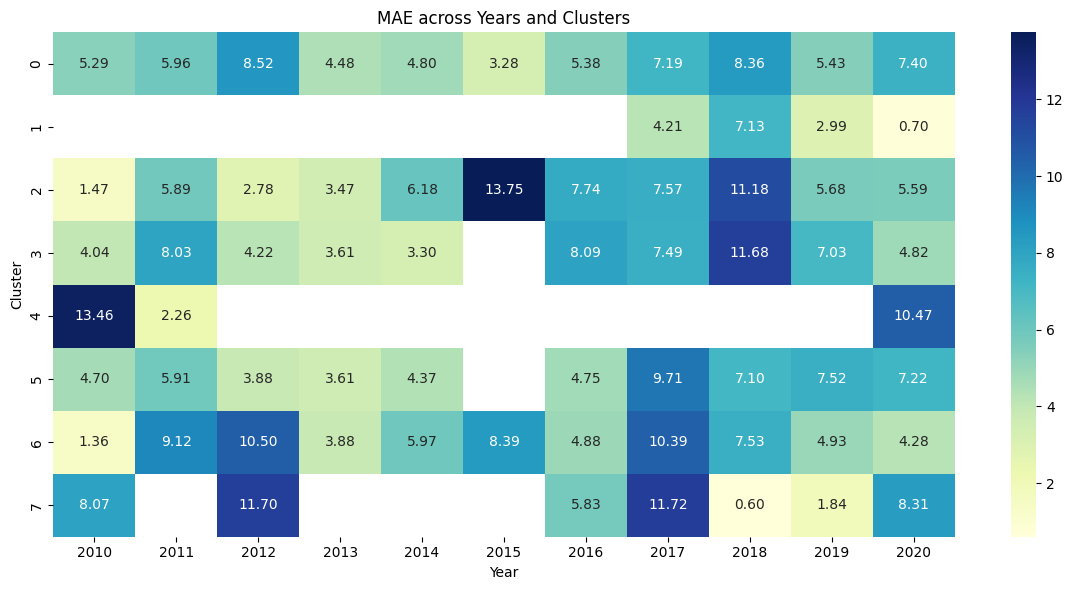

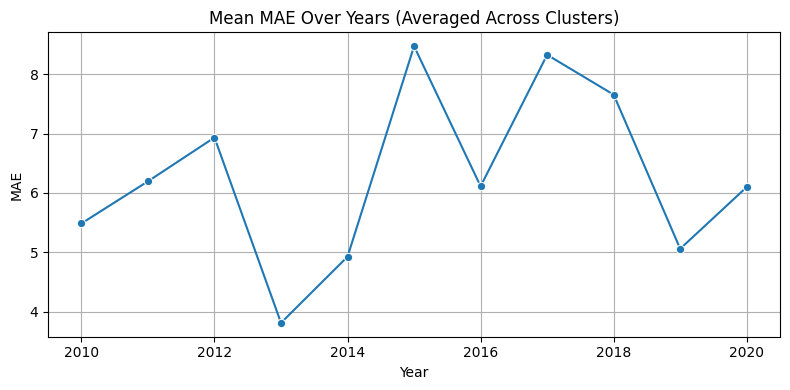

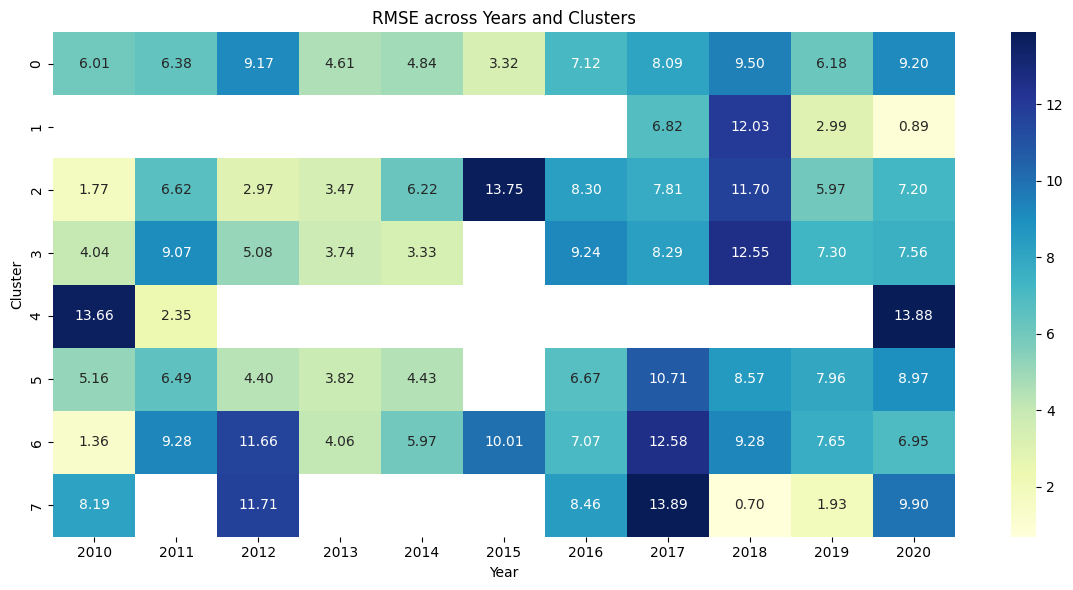

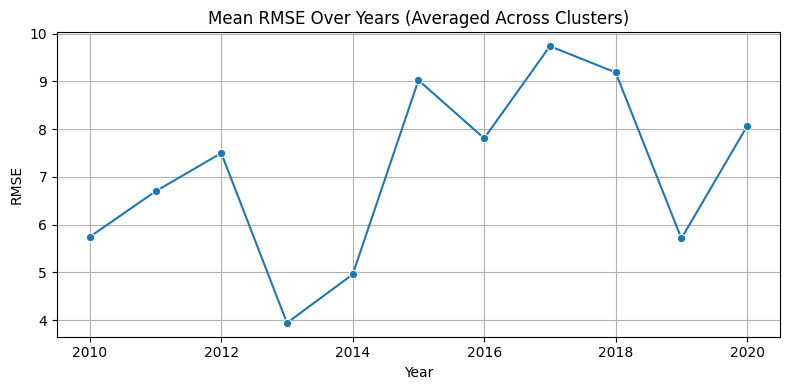

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_mae_heatmap(summary_df, metric="MAE", save_path=None):
    pivot_table = summary_df.pivot(index="Cluster", columns="Year", values=metric)
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(f"{metric} across Years and Clusters")
    plt.ylabel("Cluster")
    plt.xlabel("Year")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

def plot_mae_over_time(summary_df, metric="MAE", save_path=None):
    mean_over_years = summary_df.groupby("Year")[metric].mean()
    plt.figure(figsize=(8, 4))
    sns.lineplot(x=mean_over_years.index, y=mean_over_years.values, marker="o")
    plt.title(f"Mean {metric} Over Years (Averaged Across Clusters)")
    plt.xlabel("Year")
    plt.ylabel(metric)
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()

# Save MAE plots
plot_mae_heatmap(summary_df, metric="MAE", save_path="M8_mae_heatmap.png")
plot_mae_over_time(summary_df, metric="MAE", save_path="M8_mae_over_time.png")

# Save RMSE plots
plot_mae_heatmap(summary_df, metric="RMSE", save_path="M8_rmse_heatmap.png")
plot_mae_over_time(summary_df, metric="RMSE", save_path="M8_rmse_over_time.png")


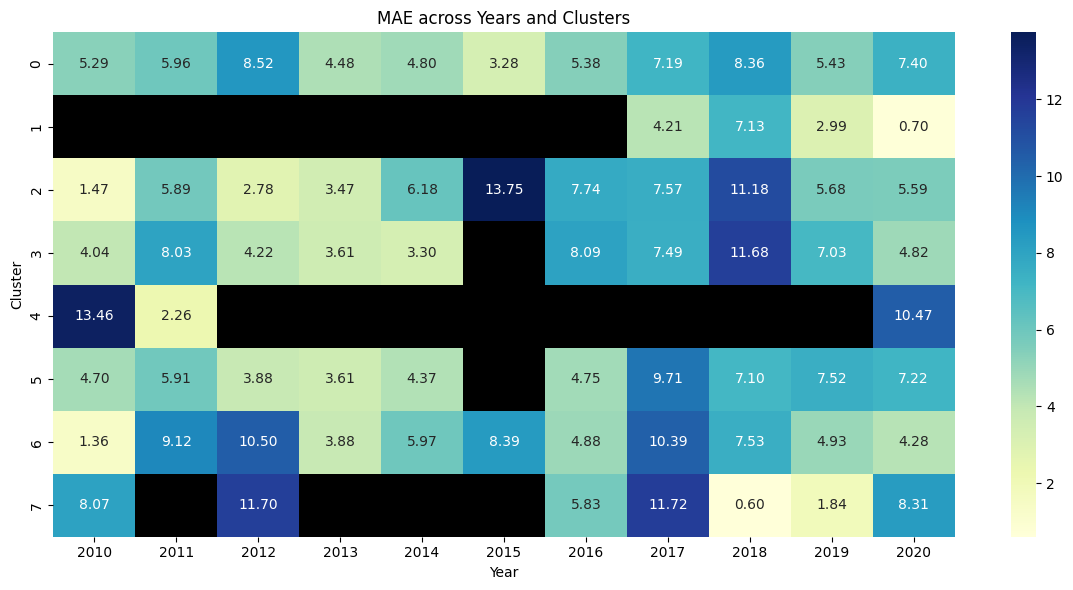

In [8]:
import matplotlib as mpl

def plot_mae_heatmap(summary_df, metric="MAE", save_path=None):
    pivot_table = summary_df.pivot(index="Cluster", columns="Year", values=metric)
    plt.figure(figsize=(12, 6))
    cmap = mpl.colormaps.get_cmap("YlGnBu").copy()  # Use .copy() to avoid modifying the global colormap
    cmap.set_bad(color="black")  # Set NaNs to black
    sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap=cmap)
    plt.title(f"{metric} across Years and Clusters")
    plt.ylabel("Cluster")
    plt.xlabel("Year")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300)
    plt.show()
# Save MAE plots
plot_mae_heatmap(summary_df, metric="MAE", save_path="M8_mae_heatmap.png")